## Neuređenost proteina u interaktomu<a id="par:toc"></a>

U radu je razmotren pojam interaktoma kao mreže proteinskih interakcija, kao i osobine i odnosi proteina u njemu. Konkretno, proučeni su interaktomi generisani na osnovu odabranog podskupa proteoma virusa *SARS-CoV-2* (membranski, nestrukturni i na kraju svi), a kao osobina od interesa izdvojena je neuređenost proteina u njima (prema različitim kriterijumima). Zadatak je bio uporediti stepen neuređenosti sa stepenom povezanosti čvora u grafu.

## Sadržaj

1. [Proteinska sekvenca](#par:protein)
2. [Neuređenost prema *IUPred*](#par:iupred)
3. [Interaktom prema *IntAct*](#par:intact)
4. [Poređenje osobina](#par:poriupred)
5. [Interaktom prema *iRefIndex*](#par:irefindex)
6. [Virusni interaktom](#par:virusni)
7. [Neuređenost prema profilu](#par:profil)
8. [Neuređenost prema *PONDR*](#par:pondr)
9. [Dužina neuređenih regiona](#par:regioni)
10. [Drugi kraj interakcije](#par:drugi)
11. [Dužina sekvence](#par:duzina)
12. [Najpovezaniji proteini](#par:habovi)
13. [Interaktom tkiva pluća](#par:pluca)

## 1. Proteinska sekvenca [⮭]<a id="par:protein"></a>

[⮭]: #par:toc

Mreža proteinskih interakcija sastoji se iz čvorova i neusmerenih veza (grana). Osnovu mreže čine čvorovi, zapravo proteini, predstavljeni klasom datom u nastavku. Protein je jednoznačno određen svojim identifikatorom (npr. [*UniProtKB*](https://www.uniprot.org/uniprot/?query=reviewed:yes)), pa je to argument konstruktora. Pri konstrukciji se dohvata *FASTA* sekvenca, koja je zapravo lepo formatirani niz aminokiselina u više redova, dok prvi red sadrži određene metapodatke o dohvaćenom proteinu.

In [1]:
# Biblioteka za HTTP zahteve
import requests

# Biblioteka za rad sa fajl sistemom
import os, os.path

# Biblioteka za dohvatanje sekvence
from Bio import Entrez

# Postavljanje nekog bez veze mejla
Entrez.email = 'mejl@mejl.rs'

# Funkcija za sigurno otvaranje fajla
def fopen(fajl, mod):
    # Pravljenje potrebnih direktorijuma
    os.makedirs(os.path.dirname(fajl), exist_ok=True)
    
    # Otvaranje fajla u željenom modu
    return open(fajl, mod)

# Klasa koja predstavlja protein
class Protein:
    # Konstruktor na osnovu identifikatora
    def __init__(self, idd, uni=True):
        # Jedinstveni identifikator
        self.id = idd
        
        # Podatak da li je UniProtKB
        self.uni = uni
        
        # Sekvenca u FASTA formatu
        try:
            # Pokušaj čitanja sa lokala
            with open(f'../fasta/{self.idd()}.fasta', 'r') as f:
                self.fasta = f.read()
        except:
            try:
                # Dohvatanje sa NCBI
                self.fasta = Entrez.efetch(db='protein',
                                           id=self.idd(),
                                           rettype='fasta',
                                           retmode='text')\
                                   .read().strip()
            except:
                # Dohvatanje sa UniProt
                self.fasta = requests\
                             .get(f'https://www.uniprot.org/uniprot/{self.idd()}.fasta')\
                             .text.strip()
            
            # Upisivanje na lokal za ubuduće
            with fopen(f'../fasta/{self.idd()}.fasta', 'w') as f:
                f.write(self.fasta)
        
        # Sekvenca prema FASTA formatu
        self.sekvenca = self.fasta[self.fasta.find('\n'):].replace('\n', '')
        
        # Dužina aminokiselinske sekvence
        self.duzina = len(self.sekvenca)
        
        # Podatak da li je ljudski
        self.ljudski = '_HUMAN' in self.fasta or 'Homo sapiens' in self.fasta
        
        # Inicijalizacija spiska interaktora
        self.interakt = []
    
    # Dohvatanje dobrog indentifikatora za pretragu
    def idd(self):
        return self.id[:6] if '-PRO_' in self.id else self.id

Na primeru *M* (membranskog) proteina *SARS-CoV-2*, identifikovanog kao [*P0DTC5*](https://www.uniprot.org/uniprot/P0DTC5), dobija se sledeća sekvenca.

In [2]:
# Membranski protein
M = Protein('P0DTC5')

# UniProt identifikator
print(M.id)
print()

# FASTA sekvenca
print(M.fasta)

P0DTC5

>sp|P0DTC5.1|VME1_SARS2 RecName: Full=Membrane protein; Short=M; AltName: Full=E1 glycoprotein; AltName: Full=Matrix glycoprotein; AltName: Full=Membrane glycoprotein
MADSNGTITVEELKKLLEQWNLVIGFLFLTWICLLQFAYANRNRFLYIIKLIFLWLLWPVTLACFVLAAV
YRINWITGGIAIAMACLVGLMWLSYFIASFRLFARTRSMWSFNPETNILLNVPLHGTILTRPLLESELVI
GAVILRGHLRIAGHHLGRCDIKDLPKEITVATSRTLSYYKLGASQRVAGDSGFAAYSRYRIGNYKLNTDH
SSSSDNIALLVQ


## 2. Neuređenost prema *IUPred* [⮭]<a id="par:iupred"></a>

[⮭]: #par:toc

Za ispitivanje strukturiranosti proteina, za početak se sa sajta [*IUPred*](https://iupred.elte.hu/) dohvataju različiti lako dostupni skorovi, poput *PPIDR* (udeo neuređenih ostataka). Konkretno, prediktor *IUPred* analizira niz aminokiselina ciljanog proteina i predviđa neuređene regione tako što procenjuje energetski potencijal za interakciju svakog ostatka. S druge strane, prediktor *ANCHOR* predviđa neuređene regione sklone povezivanju sa drugim proteinima, pri čemu postaju uređeni.

In [3]:
# Biblioteka za JSON format
import json

# Biblioteka za računanje proseka
import numpy as np

# Predikcija neuređenosti
def idr(self):
    # Odustajanje ako nije UniProt
    if not self.uni: return
    
    try:
        # Pokušaj čitanja sa lokala
        with open(f'../iupred/{self.idd()}.json', 'r') as f:
            iupreds = json.load(f)
        
        # Upisivanje vrednosti
        for prop in iupreds:
            setattr(self, prop, iupreds[prop])
    except:
        # Vrednosti ANCHOR i IUPred (long) prediktora
        anchor = json.loads(requests
                            .get(f'https://iupred3.elte.hu/iupred3/anchor/{self.idd()}.json')
                            .text)

        # Niz ANCHOR vrednosti
        anchor2 = anchor['anchor2']

        # Prosek ANCHOR vrednosti
        self.anchor_mean = np.mean(anchor2)

        # Udeo neuređenosti prema ANCHOR
        self.anchor_ppidr = np.mean([x >= .5 for x in anchor2])

        # Niz IUPred (long) vrednosti
        iupredl = anchor['iupred2']

        # Prosek IUPred (long) vrednosti
        self.iupredl_mean = np.mean(iupredl)

        # Udeo neuređenosti prema IUPred (long)
        self.iupredl_ppidr = np.mean([x >= .5 for x in iupredl])

        # Vrednosti IUPred (short) prediktora
        iupreds = json.loads(requests
                             .get(f'https://iupred3.elte.hu/iupred3/short/{self.idd()}.json')
                             .text)['iupred2']

        # Prosek IUPred (short) vrednosti
        self.iupreds_mean = np.mean(iupreds)

        # Udeo neuređenosti prema IUPred (short)
        self.iupreds_ppidr = np.mean([x >= .5 for x in iupreds])
        
        # Upisivanje na lokal za ubuduće
        with fopen(f'../iupred/{self.idd()}.json', 'w') as f:
            json.dump({'anchor_mean': self.anchor_mean,
                       'anchor_ppidr': self.anchor_ppidr,
                       'iupredl_mean': self.iupredl_mean,
                       'iupredl_ppidr': self.iupredl_ppidr,
                       'iupreds_mean': self.iupreds_mean,
                       'iupreds_ppidr': self.iupreds_ppidr}, f)

# Postavljanje za metod klase
Protein.idr = idr

Na primeru *M* proteina, dobijaju se sledeći skorovi prediktora neuređenosti. Prva dvojka je *ANCHOR*, druga *IUPred3 (long)*, a treća *IUPred3 (short)*. Prvi član dvojke je prosek ocene za sve aminokiseline, a drugi udeo ocena većih od 0,5 (granica neuređenosti). *M* protein je očigledno dobro strukturiran.

In [4]:
# Računanje neuređenosti
M.idr()

# Neuređenost prema ANCHOR
print(M.anchor_mean)
print(M.anchor_ppidr)
print()

# Neuređenost prema IUPred (long)
print(M.iupredl_mean)
print(M.iupredl_ppidr)
print()

# Neuređenost prema IUPred (short)
print(M.iupreds_mean)
print(M.iupreds_ppidr)

0.10576046719480738
0.0

0.054983389227015005
0.0

0.10085534610528028
0.04954954954954955


Ostali proučavani prediktori neuređenosti jesu: familija [*PONDR*](http://www.pondr.com/), shema *CH-CDF*, [*Composition Profiler*](http://www.cprofiler.org/cgi-bin/profiler.cgi)... Oni, međutim, nemaju lep javni *API*, pa nisu pogodni za brzu i masovnu analizu velikog broja proteina. Slično važi za baze poput [*DisProt*](https://disprot.org/) ili [*D2P2*](https://d2p2.pro/), koje pritom ni ne sadrže mnoge proteine *SARS-CoV-2*.

## 3. Interaktom prema *IntAct* [⮭]<a id="par:intact"></a>

[⮭]: #par:toc

Prvi eksperiment razmatra interaktom prema bazi [*IntAct*](https://www.ebi.ac.uk/intact/search?query=P0DTC5). Za te potrebe se preuzima spisak interakcija iz te baze, na osnovu javnog *API*-ja. Na osnovu spiska interakcija, određuje se spisak interaktora (proteina sa kojima polazni protein interaguje), što je zapravo spisak čvorova traženog interaktoma.

In [5]:
# Biblioteka za regularne izraze
import re

# Kanonsko ime interaktora
def kanonsko(prot):
    # Identifikator interaktora
    ime = prot['data']['preferred_id']
    
    # Obrada jednog posebnog slučaja
    if ime.startswith('P36956'):
        return 'P36956'
    
    # Uklanjanje specifikacije dela
    if re.search('-\d{1,2}$', ime):
        ime = ime[:ime.rfind('-')]
    
    # Vraćanje kanonskog imena
    return ime

# Spisak interaktora prema IntAct
def intact(self, skup=None):
    try:
        # Pokušaj čitanja sa lokala
        with open(f'../intact/{self.id}.json', 'r') as f:
            self.interakt = json.load(f)
    except:
        # Sve interakcije prema IntAct
        interaktom = json.loads(requests
                                .post(f'https://www.ebi.ac.uk/intact/ws/network/getInteractions?query={self.id}')
                                .text)['data']
        
        # Inicijalan skup interaktora
        self.interakt = {kanonsko(prot) for prot in interaktom
                         if prot['group'] == 'nodes' and prot['data']['preferred_id'] != self.id
                         and prot['data']['interactor_type'] == 'protein'}
        
        # Provera autointerakcije
        for inter in interaktom:
            if inter['group'] == 'edges' and inter['data']['source'] == inter['data']['target']:
                self.interakt.add(self.id)
        
        # Sortiranje svih interaktora
        self.interakt = sorted(self.interakt)
        
        # Upisivanje na lokal za ubuduće
        with fopen(f'../intact/{self.id}.json', 'w') as f:
            json.dump(self.interakt, f)
    
    # Eventualno filtriranje po skupu
    self.interakt = [prot for prot in self.interakt if skup is None or prot in skup]

# Postavljanje za metod klase
Protein.intact = intact

U konkretnom slučaju *M* proteina, dobija se 259 različitih interaktora, što je i broj čvorova u interaktomu, budući da *M* protein interaguje sam sa sobom.

In [6]:
# Određivanje interaktora prema IntAct
M.intact()

# Odštampan spisak interaktora M proteina
print(M.interakt)

['A4D1U4', 'A6NFN3', 'A7KAX9', 'O00165', 'O00217', 'O00471', 'O00482', 'O00499', 'O14678', 'O14981', 'O15063', 'O15069', 'O15287', 'O15354', 'O15374', 'O43251', 'O43399', 'O43747', 'O43752', 'O43826', 'O43852', 'O43929', 'O60318', 'O60499', 'O60674', 'O60684', 'O75306', 'O75439', 'O75448', 'O75629', 'O75691', 'O75694', 'O75841', 'O75947', 'O75953', 'O76082', 'O94788', 'O94822', 'O94829', 'O94868', 'O94919', 'O95070', 'O95299', 'O95772', 'O95786', 'O95864', 'P00403', 'P00748', 'P01031', 'P01042', 'P05026', 'P05165', 'P05166', 'P07093', 'P07858', 'P08236', 'P0C0L4-PRO_0000042698', 'P0C0L5-PRO_0000042704', 'P0DTC4', 'P0DTC5', 'P0DTC6', 'P0DTC7', 'P0DTC9', 'P0DTD1-PRO_0000449619', 'P0DTD1-PRO_0000449629', 'P0DTD8', 'P11310', 'P11498', 'P11717', 'P13804', 'P16219', 'P18850', 'P19634', 'P20700', 'P24752', 'P25686', 'P27105', 'P27144', 'P35670', 'P35916', 'P36956', 'P38435', 'P38606', 'P42126', 'P42695', 'P42898', 'P45954', 'P48047', 'P48556', 'P49116', 'P49590', 'P49810', 'P50542', 'P51589',

Kako je interaktom zapravo mreža (graf), neophodno je skupu izračunatih čvorova (proteina) pridružiti grane (veze), koje se opet mogu otkriti upitom ka razmatranoj bazi *IntAct*. Naime, za svaki protein iz grafa određuje se spisak svih interaktora. U mreži se zadržavaju one veze kod kojih su oba učesnika u spisku čvorova. Interaktom je tako predstavljen klasom u nastavku, koja dodatno podržava čuvanje u *JSON* i tabelarnom formatu.

In [7]:
# Biblioteka za rad sa tabelama
import pandas as pd

# Biblioteka za rad sa mrežama
import networkx as nx

# Klasa koja predstavlja interaktom
class Interaktom(nx.Graph):
    # Konstruktor na osnovu proteina
    def __init__(self, p={}, skup=None):
        # Forsiranje skupa proteina
        if isinstance(p, Protein):
            p = {p}
        
        # Određivanje neuređenosti polaznih
        for prot in p:
            prot.idr()
            
            # Određivanje suseda polaznih
            if prot.uni:
                prot.intact(skup)
            else:
                prot.irefindex(skup)
        
        # Jedinstveni identifikatori
        self.ids = {pp.id for pp in p}
        
        # Skup svih potencijalnih interaktora
        skup = self.ids
        for pp in p:
            skup = {*skup, *pp.interakt}
        skup = sorted(skup)
        
        # Proteini prema identifikatoru u klasi
        self.prots = [Protein(prot, pp.uni) for prot in skup]
        
        # Incijalizacija natklase
        super().__init__()
        
        # Određivanje neuređenosti svih
        for prot in self.prots:
            prot.idr()
            
            # Određivanje svih suseda
            if prot.uni:
                prot.intact(skup)
            else:
                prot.irefindex(skup)
    
    # Čuvanje interaktoma na disku
    def sacuvaj(self, ime):
        # Čuvanje interaktoma u JSON formatu
        with fopen(f'../json/{ime}.json', 'w') as f:
            json.dump({prot.id: prot.interakt for prot in self.prots}, f)
        
        # Mapa za proveru saglasnosti
        mapa = {prot.id: prot.interakt for prot in self.prots}
        
        # Provera saglasnosti
        for p1 in mapa:
            for p2 in mapa[p1]:
                if p2 in mapa and p1 not in mapa[p2]:
                    raise ValueError
        
        # Prazna tabela sa odgovarajućim kolonama
        tabela = pd.DataFrame(columns=['Broj suseda', 'Spisak suseda'])
        
        # Prolazak kroz sve proteine
        for prot in self.prots:
            # Određivanje broja suseda
            prot.susedi = len(prot.interakt)
            
            # Dodavanje čvora u graf
            self.add_node(prot.id)

            # Dodavanje grane u graf
            for p in prot.interakt:
                self.add_edge(prot.id, p)
            
            # Dodavanje svih proteina u tabelu
            tabela.loc[prot.id] = [prot.susedi, prot.interakt]
        
        # Čuvanje interaktoma u tabelarnom formatu
        with fopen(f'../csv/{ime}.csv', 'w') as f:
            tabela.to_csv(f)
        
        # Prikaz tabele u svesci
        display(tabela)

Klasa se lako upotrebljava za predviđanje interaktoma razmatranog *M* proteina. Pri čuvanju se generiše tabela susedstva, koja je prikazana u nastavku.

In [8]:
# Interaktom M proteina
M_intact = Interaktom(M)

# Čuvanje u JSON formatu
M_intact.sacuvaj('M_IntAct')

,Broj suseda,Spisak suseda
A4D1U4,1,[P0DTC5]
A6NFN3,2,"[P0DTC5, Q99963]"
A7KAX9,2,"[A7KAX9, P0DTC5]"
O00165,4,"[O00165, P0DTC5, P51617, Q9H4G0]"
O00217,2,"[P0DTC5, P42695]"
...,...,...
Q9Y672,2,"[P0DTC5, P0DTD8]"
Q9Y6A1,2,"[P0DTC5, Q9Y6A1]"
Q9Y6D5,4,"[P0DTC5, Q9BRK5, Q9UPT5, Q9Y6D6]"
Q9Y6D6,3,"[P0DTC5, P0DTC7, Q9Y6D5]"


Moguće je nacrtati i samu rezultujuću mrežu, i to najbolje bez interakcija u kojima protein učestvuje sam sa sobom, kao i bez razmatranog proteina. Tako se bolje vidi povezanost ostalih čvorova, odnosno uočavaju eventualni habovi. U konkretnom slučaju *M* proteina, primetno je da je mreža donekle povezana. Što se tiče samog prikaza, postoji namerna razlika u boji čvorova: plavim kružićima označeni su ljudski, a narandžastim virusni proteini.

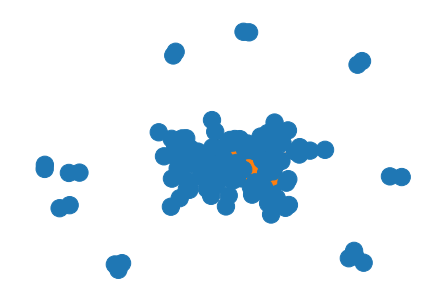

In [9]:
# Određivanje boje čvorova
boja = lambda prot: '#1f77b4' if Protein(prot).ljudski else '#ff7f0e'

# Crtanje mreže pomoću biblioteke
def crtaj(fajl, skup):
    # Provera da li je mapa imena
    mapa = isinstance(skup, dict)
    
    # Učitavanje sačuvanog interaktoma
    with open(fajl, 'r') as f:
        inter = json.load(f)
    
    # Inicijalizacija grafa
    mreza = nx.Graph()
    
    # Prolazak kroz sve čvovore
    for k in inter:
        # Preskakanje gustih čvovora
        if not mapa and k in skup:
            continue
        
        # Prolazak kroz sve grane
        for v in inter[k]:
            # Preskakanje petlji i gustih cvorova
            if not mapa and v in skup or k == v:
                continue
            
            # Dodavanje grane u graf
            mreza.add_edge(k, v)
    
    # Inicijalno prazan spisak boja
    boje = []
    
    # Određivanje boje čvorova
    for node in mreza.nodes:
        boje.append(boja(node))
    
    # Sređivanje skupa
    skup = {k: skup[k] for k in skup if k in mreza.nodes}
    
    # Crtanje konačnog grafa
    if mapa:
        nx.draw(mreza, node_color=boje,
                labels=skup, with_labels=True)
    else:
        nx.draw(mreza, node_color=boje)

# Crtanje interaktoma M proteina
crtaj('../json/M_IntAct.json', M_intact.ids)

Moguće je napraviti i potpuno interaktivan graf, uz napomenu da je on gust i nepregledan za velike interaktome. U ovom grafu je, međutim, mišem moguće pomerati čvorove. Veličina čvorova srazmerna je povezanosti u interaktomu. Čvorovi koji predstavljaju virusne proteine označeni su kratkim simbolima (s tim u vezi, u nastavku je dat spisak proteina *SARS-CoV-2*, podeljenih po grupama), dok su ljudski označeni *UniProtKB* ili *NCBI* identifikatorima. Prelazom mišem preko svakog čvora takođe se dobija njegov identifikator, sa stepenom povezanosti u zagradi. Podrazumevana topologija prikaza je zvezda.

In [10]:
# Biblioteka za interaktivne mreže
import pyvis.network as pyn

# Strukturni proteini i njihove UniProtKB oznake
SARS = {'P0DTC2': 'S', 'P0DTC4': 'E', 'P0DTC5': 'M', 'P0DTC9': 'N',
# Nestrukturni proteini i njihove NCBI oznake
        'YP_009725297': 'Nsp1' , 'YP_009725298': 'Nsp2' , 'YP_009725299': 'Nsp3' ,
        'YP_009725300': 'Nsp4' , 'YP_009725301': 'Nsp5' , 'YP_009725302': 'Nsp6' ,
        'YP_009725303': 'Nsp7' , 'YP_009725304': 'Nsp8' , 'YP_009725305': 'Nsp9' ,
        'YP_009725306': 'Nsp10', 'YP_009725307': 'Nsp12', 'YP_009725308': 'Nsp13',
        'YP_009725309': 'Nsp14', 'YP_009725310': 'Nsp15', 'YP_009725311': 'Nsp16',
# Pomoćni proteini i njihove UniProtKB oznake
        'P0DTC3': 'ORF3a', 'P0DTF1': 'ORF3b', 'P0DTG1': 'ORF3c', 'P0DTG0': 'ORF3d',
        'P0DTC6': 'ORF6' , 'P0DTC7': 'ORF7a', 'P0DTD8': 'ORF7b', 'P0DTC8': 'ORF8' ,
        'P0DTD2': 'ORF9b', 'P0DTD3': 'ORF9c', 'A0A663DJA2': 'ORF10'}

# Interaktivni interaktom
def pyvis(fajl, skup=set()):
    # Učitavanje sačuvanog interaktoma
    with open(fajl, 'r') as f:
        inter = json.load(f)
    
    # Inicijalizacija mreže
    mreza = pyn.Network('750px', '750px', notebook=True)
    
    # Prolazak kroz sve čvorove
    for k in inter:
        # Preskakanje gustih čvorova
        if k in skup: continue
        
        # Dodavanje ostalih čvorova
        mreza.add_node(k, title=f'{k} [{len(inter[k])}]',
                       color=boja(k), value=len(inter[k]),
                       label=SARS[k] if k in SARS else k)
    
    # Prolazak kroz sve čvovore
    for k in inter:
        # Preskakanje gustih čvovora
        if k in skup: continue
        
        # Prolazak kroz sve grane
        for v in inter[k]:
            # Preskakanje petlji i gustih cvorova
            if v in skup or skup and k == v:
                continue
            
            # Dodavanje grane u graf
            mreza.add_edge(k, v)
    
    # Isključivanje fizike
    mreza.toggle_physics(False)
    
    # Lociranje rezultujuće mreže
    fajl = fajl[:-5].replace('json', 'html') + \
           ('_part.html' if skup else '_full.html')
    
    # Pravljenje potrebnih direktorijuma
    os.makedirs(os.path.dirname(fajl), exist_ok=True)
    
    # Generisanje rezultujuće mreže
    mreza = mreza.show(fajl)
    
    # Prikaz rezultujuće mreže
    display(mreza)

# Crtanje interaktoma M proteina
pyvis('../json/M_IntAct.json')

Preglednosti radi, i ovde je moguće uprostiti mrežu isključivanjem razmatranog proteina, kao i autointerakcija. Preglednost, međutim, ostaje nezavidna.

In [11]:
# Crtanje interaktoma M proteina
pyvis('../json/M_IntAct.json', M_intact.ids)

## 4. Poređenje osobina [⮭]<a id="par:poriupred"></a>

[⮭]: #par:toc

Sada je moguće grafički uporediti stepen povezanosti čvora sa prethodno izračunatim stepenima neuređenosti. Poređenje je jednostavno: proteini su prikazani u dvodimenzionom prostoru, pri čemu je na horizontalnoj osi predstavljen stepen povezanosti u interaktomu (nenegativan ceo broj), dok vertikalna osa oslikava stepen neuređenosti istog proteina (realna vrednost između nule i jedinice). Ucrtana je i procenjena gustina zajedničke raspodele (*KDE*), dok se u legendi nalazi tabela kontigencije koja deli raspodelu na kvadrante. Po rezultatima se čini da mreža izgleda uobičajeno za jedan interaktom (npr. ima veliki broj čvorova malog stepena, ali i mali broj visokopovezanih čvorova), ali se ne primećuje linearna veza sa stepenom neuređenosti.

In [12]:
# Biblioteka za upozorenja
import warnings

# Biblioteka za crtanje raspodele
import seaborn as sns

# Biblioteka za tabelrianje
from tabulate import tabulate

# Biblioteka za grafički prikaz
import matplotlib.pyplot as plt

# Biblioteka za korelaciju
from scipy.stats import spearmanr

# Biblioteka za programatko dodavanje slika
from IPython.core.display import HTML

# Indikator crtanja statistika
stat = False

# Indikator tekućeg interaktoma
intind = None

# Određivanje granica podele
def razgranici(X, Y, q=.982):
    # Određivanje horizontalne granice
    Xsred = np.quantile(X, q)
    
    # Izdvajanje vertikalnih ekstrema
    Ymin, Ymax = min(Y), max(Y)
    
    # Određivanje vertikalne granice
    Ysred = max(.3, .3*Ymax)
    
    # Popravka kod hidropatije
    if Ysred <= Ymin:
        Ysred = .7*Ymin + .3*Ymax
    
    # Vraćanje granica podele
    return Xsred, Ysred

# Prebrojavanje članova kvadranata
def tabeliraj(X, Y, Xsred, Ysred):
    # Levi donji kvadrant
    ld = sum(np.logical_and(X <= Xsred, Y <= Ysred))
    
    # Levi gornji kvadrant
    lg = sum(np.logical_and(X <= Xsred, Y > Ysred))
    
    # Desni donji kvadrant
    dd = sum(np.logical_and(X > Xsred, Y <= Ysred))
    
    # Desni gornji kvadrant
    dg = sum(np.logical_and(X > Xsred, Y > Ysred))
    
    # Vraćanje rezultata
    return ld, lg, dd, dg

# Crtanje poređenja mera
def porplot(X, Y, Z, ax, q=.982):
    # Prilagođavanje tipa podataka
    Z = np.array(Z)
    
    # Crtanje ljudskih proteina
    ax.scatter(X[Z], Y[Z])
    
    # Crtanje neljudskih proteina
    ax.scatter(X[~Z], Y[~Z])
    
    # Pamćenje starih granica
    vertikalne = ax.get_ylim()
    horizontalne = ax.get_xlim()
    
    # Ucrtavanje gustine raspodele
    sns.kdeplot(x=X, y=Y, color='gray', alpha=.2, ax=ax)
    
    # Vraćanje starih granica
    ax.set_ylim(vertikalne)
    ax.set_xlim(horizontalne)
    
    # Odluka o podeli prostora
    if not intind:
        # Računanje korelacije
        rho, p = spearmanr(X, Y)

        # Određivanje značajnosti
        p = '*' if p < .05 else ''

        # Upisivanje korelacije
        ax.plot([], [], ' ', label=f'ρ = {rho:.2f}{p}')

        # Kraj bez podele prostora
        return
    
    # Određivanje granica podele
    Xsred, Ysred = razgranici(X, Y, q)
    
    # Razgraničavanje kvadranata
    ax.axvline(Xsred, ls=':', color='black', alpha=.2)
    ax.axhline(Ysred, ls=':', color='black', alpha=.2)
    
    # Prebrojavanje članova kvadranata
    ld, lg, dd, dg = tabeliraj(X, Y, Xsred, Ysred)
    
    # Tabeliranje članova kvadranata
    ax.plot([], [], ' ', label=tabulate([[lg, dg],
                                         [ld, dd]], tablefmt='grid'))

# Crtanje proteina prema vrsti
def plotuj(X, Y, Z, ax, ime, q=.982):
    # Prilagođavanje tipa podataka
    X, Y = np.array(X), np.array(Y)
    
    # Postavljanje naziva grafika
    ax.set_title(ime, fontsize=10)
    
    # Dohvatanje vertikalne granice
    dno, vrh = ax.get_ylim()
    
    # Postavljanje vertikalne granice
    ax.set_ylim(min(-.05, dno, -.05 * max(Y)),
                max(1.05, vrh, 1.05 * max(Y)))
    
    # Crtanje poređenja ili statistika
    statplot(X, Y, ax) if stat else porplot(X, Y, Z, ax, q)
    
    # Crtanje legende
    ax.legend(prop={'family': 'monospace', 'size': 8.5},
              loc=1, handlelength=0, handletextpad=0)

# Čuvanje i crtanje slike
def oslobodi(fig, sup):
    # Ime datoteke koja se pravi
    dat = f'../fig/{sup}.svg'
    
    # Oslobađanje od novog reda
    dat = dat.replace('\n', '')
    
    # Pravljenje potrebnih direktorijuma
    os.makedirs(os.path.dirname(dat), exist_ok=True)
    
    # Naslov grafika koji opisuje sliku
    fig.suptitle(sup, fontsize=12)
    
    # Zanemarivanje nevažnih upozorenja
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        # Crtanje grafika bez preklapanja
        fig.tight_layout()
    
    # Čuvanje u kvalitetnom SVG formatu
    fig.savefig(dat, bbox_inches='tight')
    
    # Oslobađanje memorije grafika
    plt.close(fig)
    
    # HTML prikaz sačuvane slike
    display(HTML(f'<img src="{dat}"/>'))

# Poređenje prema IntAct
def poredi(interakt, ime, ax=None):
    # Podela slike na više delova
    fig, axs = plt.subplots(2, 3, figsize=(10, 6),
                           sharex=True, sharey=True)

    # Inicijalno prazne liste koordinata
    X, Y, Z = [], [[[], [], []], [[], [], []]], []

    # Prolazak kroz sve proteine sem polaznih
    for prot in interakt.prots:
        if prot.id in interakt.ids:
            continue

        # Novi stepen povezanosti
        X.append(prot.susedi)
        
        # Novi podatak o poreklu proteina
        Z.append(prot.ljudski)

        # Nove ANCHOR mere neuređenosti
        Y[0][0].append(prot.anchor_mean)
        Y[1][0].append(prot.anchor_ppidr)

        # Nove IUPred (long) mere neuređenosti
        Y[0][1].append(prot.iupredl_mean)
        Y[1][1].append(prot.iupredl_ppidr)

        # Nove IUPred (short) mere neuređenosti
        Y[0][2].append(prot.iupreds_mean)
        Y[1][2].append(prot.iupreds_ppidr)
    
    # Indikator tekućeg interaktoma
    global intind
    intind = ime

    # Crtanje svih određenih mera
    plotuj(X, Y[0][0], Z, axs[0, 0], 'Stepen naspram ANCHOR proseka')
    plotuj(X, Y[1][0], Z, axs[1, 0], 'Stepen naspram ANCHOR udela')
    plotuj(X, Y[0][1], Z, axs[0, 1], 'Stepen naspram IUPred (long) proseka')
    plotuj(X, Y[1][1], Z, axs[1, 1], 'Stepen naspram IUPred (long) udela')
    plotuj(X, Y[0][2], Z, axs[0, 2], 'Stepen naspram IUPred (short) proseka')
    plotuj(X, Y[1][2], Z, axs[1, 2], 'Stepen naspram IUPred (short) udela')

    # Čuvanje i crtanje slike
    oslobodi(fig, ime)
    
    # Vraćanje izračunatih mera
    return X, Y

# Poređenje prema IntAct
X, Y = poredi(M_intact, 'IUPred i ANCHOR – zajednička raspodela')

Grafici mogu biti varljivi ukoliko se ne uzme u obzir tačna uslovna raspodela neuređenosti prema stepenu. Stoga je značajno posebno prikazati srednje vrednosti tih raspodela, a dodatno je korisno obogatiti prikaz ucrtavanjem standardnog odstupanja, što je i učinjeno u nastavku. Tako se tačno vidi koliko su proteini određenog stepena zapravo u globalu (prosečno) neuređeni, kao i koliko je ta procena stabilna (stabilnost ocene obrnuto je srazmerna odstupanju). Prikazana je i uslovna raspodela u suprotnom smeru: stepen povezanosti uslovljen neuređenošću, s tim što su tu vrednosti grupisane po desetinama.

In [13]:
# Crtanje statistika mera
def statplot(X, Y, ax):
    # Inicijalizacija statistika
    x, m, s = [], [], []
    
    # Prolazak kroz različite stepene
    for i in set(X):
        x.append(i)
    
        # Srednja vrednost na stepenu
        m.append(np.mean(Y[X == i]))

        # Standardno odstupanje na stepenu
        s.append(np.std(Y[X == i]))
    
    # Crtanje izračunatih statistika
    ax.errorbar(x, m, yerr=s,
                linestyle='None',
                marker='x', color='r',
                elinewidth=.5)
    
    # Računanje korelacije
    rho, p = spearmanr(x, m)
    
    # Određivanje značajnosti
    p = '*' if p < .05 else ''
    
    # Upisivanje korelacije
    if max(Y) > 1:
        ax.plot([], [], ' ', label=f'ρ = {rho:.2f}{p}')
        
        # Kraj ukoliko nije mala mera
        return
    
    # Upisivanje korelacije
    ax.plot([], [], ' ', label=f'ρ[X] = {rho:.2f}{p}')
    
    # Inicijalizacija statistika
    y, m, s = [], [], []
    
    # Prolazak kroz sve podele
    for i in np.arange(.05, 1, .1):
        # Određivanje podele
        niz = X[np.logical_and(Y < i + .05, Y >= i - .05)]
        
        # Preskakanje praznog niza
        if not niz.size: continue
        
        # Predstavnik tekuće podele
        y.append(i)
        
        # Srednja vrednost na podeli
        m.append(np.mean(niz))
        
        # Standardno odstupanje na podeli
        s.append(np.std(niz))
    
    # Crtanje izračunatih statistika
    ax.errorbar(m, y, xerr=s,
                linestyle='None',
                marker='x', color='b',
                elinewidth=.5)
    
    # Računanje korelacije
    rho, p = spearmanr(y, m)
    
    # Određivanje značajnosti
    p = '*' if p < .05 else ''
    
    # Upisivanje korelacije
    ax.plot([], [], ' ', label=f'ρ[Y] = {rho:.2f}{p}')

# Prikaz uslovnih raspodela
def statistike(interakt, ime, ax=None):
    # Dohvatanje globalne promenljive
    global stat
    
    # Postavljanje indikatora statistika
    stat = True
    
    # Statistike prema interaktomu
    poredi(interakt, ime, ax)
    
    # Poništavanje indikatora statistika
    stat = False

# Poređenje prema IntAct
statistike(M_intact, 'IUPred i ANCHOR – uslovna raspodela')

Na prethodnim graficima moguće je primetiti karakterističnu situaciju koja proizilazi iz podele na kvadrante. S jedne strane, donji levi kvadrant je najpopunjeniji, dok je s druge gornji desni prilično prazan. Preostala dva su značajna jer ukazuju na suprotstavljajući odnos povezanosti i neuređenosti i sadrže manji broj proteina. Stoga je korisno ispitati prosečnu neuređenost u levom, odnosno desnom delu grafika, kao i prosečnu povezanost u donjem, odnosno gornjem delu dijagrama. Na prikazu koji sledi nalaze se trakasti dijagrami sa srednjim vrednostima, kao i legenda sa Kramerovom merom povezanosti ($\phi$) i različitim Spirmanovim korelacijama ($\rho$). Kramer svedoči o tome koliko su zastupljenije tačke u značajnim kvadrantima u odnosu na najprazniji. Spirman procenjuje monotonu (rangovsku, ne nužno linearnu) vezu između stepena povezanosti i neuređenosti. Čini se da su najpovezaniji čvorovi u proseku uređeniji od ostalih.

In [14]:
# Biblioteka za merenje povezanosti
from scipy.stats.contingency import association

# Odabrane particije čvovora
bars = ['X [↑]', 'X [↓]', 'Y [→]', 'Y [←]']

# Maksimalni stepen za skaliranje
skala = None

# Momenti potencijalno praznog niza
srednja = lambda niz: np.mean(niz) if niz else 0
stdodst = lambda niz: np.std(niz) if niz else 0

# Proširivanje spiskova
def dodaj(X, Y, P, uslov, pros, ods, kor, ozn):
    # Ograničavanje nad uslovom
    Xu, Yu = X[uslov], Y[uslov]
    
    # Proširivanje spiska proseka
    if P is X:
        pros.append(srednja([*Xu])/skala)
        ods.append(stdodst([*Xu])/skala)
    else:
        pros.append(srednja([*Yu]))
        ods.append(stdodst([*Yu]))
    
    # Proširivanje spiska oznaka
    ozn.append(srednja([*Xu]) if P is X else srednja([*Yu]))

# Upisivanje korelacije
def korelacija(X, Y, uslov, simbol, ax):
    
    # Zanemarivanje nevažnih upozorenja
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        # Računanje korelacije
        rho, p = spearmanr(X[uslov], Y[uslov])
    
    # Određivanje značajnosti
    p = '*' if p < .05 else ''
    
    # Upisivanje korelacije
    ax.plot([], [], ' ', label=f'ρ[{simbol}] = {rho:.2f}{p}')

# Prosečna neuređenost
def prosek(X, Y, ax, ime, q=.982):
    # Prilagođavanje tipa podataka
    X, Y = np.array(X), np.array(Y)
    
    # Skladištenje horizontalnog maksimuma
    global skala
    skala = max(X)
    
    # Zanemarivanje skale ako nije potrebna
    skala = skala if skala and max(Y) <= 1 and q else 1
    
    # Niz proseka, odstupanja i oznaka
    pros, ods, ozn, kor = [], [], [], []
    
    # Određivanje granica podele
    Xsred, Ysred = razgranici(X, Y, q)
    
    # Prosek gornjih čvorova
    dodaj(X, Y, X, Y > Ysred, pros, ods, kor, ozn)
    
    # Prosek donjih čvorova
    dodaj(X, Y, X, Y <= Ysred, pros, ods, kor, ozn)
    
    # Prosek desnih čvorova
    dodaj(X, Y, Y, X > Xsred, pros, ods, kor, ozn)
    
    # Prosek levih čvorova 
    dodaj(X, Y, Y, X <= Xsred, pros, ods, kor, ozn)
    
    # Prolazak kroz sve proseke
    for i in range(len(pros)):
        # Skaliranje odstupanja
        ods[i] /= 4
        
        # Skaliranje prevelikih proseka
        if pros[i] > 100:
            pros[i] /= 15
            
            # Skaliranje prevelikih odstupanja
            ods[i] /= 15
    
    # Jednostavno određivanje indeksa
    y = np.arange(len(bars))
    
    # Stubići sa prosečnim neuređenostima
    hb = ax.barh(y, pros, xerr=ods, alpha=.8,
                 color='mediumseagreen')
    
    # Postavljanje imena grafika
    ax.set_title(ime, fontsize=10)
    
    # Ispisivanje particija čvorova
    ax.set_yticks(y, labels=bars)
    
    # Sređivanje oznaka
    ozn = map(lambda x: f'{x:.2f}', ozn)

    # Ispisivanje proseka neuređenosti
    ax.bar_label(hb, ozn, fontsize=8.5)
    
    # Brisanje nepotrebnih oznaka
    ax.tick_params(axis='x', bottom=False, labelbottom=False)
    
    # Povećavanje fonta ispisa
    ax.tick_params(axis='y', labelsize=11)
    
    # Dohvatanje horizonralne granice
    _, desno = ax.get_xlim()
    
    # Fino podešavanje desne granice
    ax.set_xlim(0, max(desno, 3*max(pros) + max(ods)))
    
    # Prebrojavanje članova kvadranata
    _, lg, dd, dg = tabeliraj(X, Y, Xsred, Ysred)
    
    # Kramerova mera povezanosti
    phi = association([[lg, dg],
                       [ 0, dd]]) if lg and dd else 0
    
    # Upisivanje mere povezanosti
    ax.plot([], [], ' ', label=f'φ = {phi:.5f}')
    
    # Parametri za sve korelacije
    uslovi = {'✻': np.full_like(X, True, dtype=bool),
              '←': X <= Xsred,
              '→': X > Xsred,
              '↓': Y <= Ysred,
              '↑': Y > Ysred}
    
    # Računanje svih korelacija
    for simbol, uslov in uslovi.items():
        korelacija(X, Y, uslov, simbol, ax=ax)
    
    # Određivanje lokacije legende
    loc = 3 * (np.argmax(pros) > 1) + 1
    
    # Crtanje legende
    ax.legend(prop={'family': 'monospace', 'size': 8.5},
              loc=loc, handlelength=0, handletextpad=0)

# Stubići sa prosečnom neuređenošću
def barplot(X, Y, ime):
    # Podela slike na više delova
    fig, axs = plt.subplots(2, 3, figsize=(10, 6),
                           sharex=True, sharey=True)

    # Crtanje svih određenih mera
    prosek(X, Y[0][0], axs[0, 0], 'Stepen naspram ANCHOR proseka')
    prosek(X, Y[1][0], axs[1, 0], 'Stepen naspram ANCHOR udela')
    prosek(X, Y[0][1], axs[0, 1], 'Stepen naspram IUPred (long) proseka')
    prosek(X, Y[1][1], axs[1, 1], 'Stepen naspram IUPred (long) udela')
    prosek(X, Y[0][2], axs[0, 2], 'Stepen naspram IUPred (short) proseka')
    prosek(X, Y[1][2], axs[1, 2], 'Stepen naspram IUPred (short) udela')

    # Čuvanje i crtanje slike
    oslobodi(fig, ime)

# Stubići sa prosečnom neuređenošću
barplot(X, Y, 'IUPred i ANCHOR – proseci po podeli')

Naravno, kompletnosti radi, nije loše prikazati ni pojedinačnu raspodelu mera neuređenosti. To je i učinjeno u nastavku, u vidu nekoliko histograma. Dodatno su u uglu prikazani histogrami uslovne raspodele mera neuređenosti na osnovu podele po stepenima povezanosti, što dopunjuje prethodni prikaz.

In [15]:
# Biblioteka za dodavanje pomoćnih osa
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Sređivanje grafika posle histograma
def sredi(ax, ymax, ime=None):
    # Postavljanje boje krive
    if ax.lines:
        ax.lines[0].set_color('crimson')
    
    # Brisanje neželjenog imena ose
    ax.set_ylabel(None)
    
    # Postavljanje naziva grafika
    ax.set_title(ime, fontsize=10)
    
    # Dohvatanje horizontalne granice
    _, desno = ax.get_xlim()
    
    # Postavljanje horizontalne granice
    ax.set_xlim(-.05, max(1.05, desno, 1.05 * ymax))

# Histogram sa raspodelom neuređenosti
def histoidp(X, Y, ax, ime, q=.982):
    # Crtanje histograma raspodele
    sns.histplot(Y, kde=True, element='step',
                 color='goldenrod', ax=ax)
    
    # Horizontalna granica
    Ymax = max(Y)
    
    # Sređivanje grafika posle histograma
    sredi(ax, Ymax, ime)
    
    # Prilagođavanje tipa podataka
    X, Y = np.array(X), np.array(Y)
    
    # Određivanje granice podele
    X = X <= np.quantile(X, q)
    
    # Izdvajanje dva podeljena skupa
    Y = Y[X], Y[~X]
    
    # Ubacivanje pomoćne ose u ugao
    ins = inset_axes(ax, width='40%', height='40%')
    
    # Crtanje histograma levo od granice
    sns.histplot(Y[0], element='step', stat='density', alpha=.4,
                 color='mediumorchid', label='←', ax=ins)
    
    # Crtanje histograma desno od granice
    sns.histplot(Y[1], element='step', stat='density', alpha=.4,
                 color='olive', label='→', ax=ins)
    
    # Sređivanje grafika posle histograma
    sredi(ins, Ymax)
    
    # Sakrivanje svih oznaka
    ins.tick_params(which='both', colors=(0, 0, 0, 0))
    
    # Crtanje legende pomoćne ose
    ins.legend(borderpad=.3, labelspacing=0, handlelength=-.2,
               handletextpad=.3, borderaxespad=.3, fontsize=12)

# Histogrami sa raspodelom neuređenosti
def raspodela(X, Y, ime):
    # Podela slike na više delova
    fig, axs = plt.subplots(2, 3, figsize=(10, 6))

    # Crtanje svih određenih mera
    histoidp(X, Y[0][0], axs[0, 0], 'Raspodela ANCHOR proseka')
    histoidp(X, Y[1][0], axs[1, 0], 'Raspodela ANCHOR udela')
    histoidp(X, Y[0][1], axs[0, 1], 'Raspodela IUPred (long) proseka')
    histoidp(X, Y[1][1], axs[1, 1], 'Raspodela IUPred (long) udela')
    histoidp(X, Y[0][2], axs[0, 2], 'Raspodela IUPred (short) proseka')
    histoidp(X, Y[1][2], axs[1, 2], 'Raspodela IUPred (short) udela')

    # Čuvanje i crtanje slike
    oslobodi(fig, ime)

# Histogrami sa raspodelom neuređenosti
raspodela(X, Y, 'IUPred i ANCHOR – pojedinačna raspodela')

## 5. Interaktom prema *iRefIndex* [⮭]<a id="par:irefindex"></a>

[⮭]: #par:toc

Nestrukturni proteini *SARS-CoV-2*, koje kodira *ORF1ab*, nisu zabeležni u uobičajenim bazama proteina. Štaviše, čak ih i poznati *UniProt* uopšteno smatra jednim velikim poliproteinom, identifikovanim kao [*P0DTD1*](https://www.uniprot.org/uniprot/P0DTD1) (replikaza *1ab*). Ipak, njihovi *RefSeq* ([*NCBI*](https://www.ncbi.nlm.nih.gov/Structure/SARS-CoV-2.html)) identifikatori ih jednoznačno određuju.

In [16]:
# Nestrukturni proteini SARS-CoV-2
Nsp = {prot for prot in SARS if prot.startswith('YP_')}

# Nestrukturni proteini u klasi
Nsp = {Protein(nsp, False) for nsp in Nsp}

Njihove interakcije mogu se naći u bazi [*iRefIndex*](https://irefindex.vib.be/), odnosno preko objedinjenog sistema [*PSICQUIC*](http://www.ebi.ac.uk/Tools/webservices/psicquic/view/home.xhtml), i to takođe kroz javni *API*. Ova baza sadrži znatno veći broj interakcija od prethodno razmatrane *IntAct*, pri čemu je to jedna od najvećih baza povezanih sa *PSICQUIC*, tako da je vrlo korisna za rad.

In [17]:
# Biblioteka za čitanje iz niske
import io

# Spisak interaktora prema iRefIndex
def irefindex(self, skup=None):
    try:
        # Pokušaj čitanja sa lokala
        with open(f'../irefindex/{self.id}.json', 'r') as f:
            self.interakt = json.load(f)
    except:
        # Sve interakcije prema iRefIndex
        inter = io.StringIO(requests
                            .get(f'http://irefindex.vib.be/webservices/current/search/interactor/{self.id}')
                            .text)
        
        # Tabela svih interakcija prema spisku
        tabela = pd.read_table(inter, header=None) if inter.getvalue() else pd.DataFrame()

        # Inicijalno prazan skup interaktora
        self.interakt = set()

        # Prolazak kroz sve interakcije iz tabele
        for tab in tabela.iterrows():
            # Provera autointerakcije
            if tab[1][0] == tab[1][1]:
                self.interakt.add(self.id)
            
            # Provera ostalih interakcija
            for i in range(2):
                prot = tab[1][i]
                
                # Provera da li je protein
                pocetak = prot[:prot.find(':')]
                if pocetak not in ('uniprotkb', 'refseq'):
                    continue

                # Određivanje indentifikatora
                prot = prot[prot.find(':')+1:]

                # Dodavanje u skup interaktora
                if prot != self.id:
                    self.interakt.add(prot)
        
        # Sortiranje svih interaktora
        self.interakt = sorted(self.interakt)
        
        # Upisivanje na lokal za ubuduće
        with fopen(f'../irefindex/{self.id}.json', 'w') as f:
            json.dump(self.interakt, f)
    
    # Eventualno filtriranje po skupu
    self.interakt = [prot for prot in self.interakt if skup is None or prot in skup]

# Postavljanje za metod klase
Protein.irefindex = irefindex

I ovaj interaktom može se predvideti, sačuvati, prikazati tabelarno i nacrtati kao mreža (graf) sa odabranim čvorovima i granama.

In [18]:
# Interaktom nestrukturnih proteina
Nsp_iref = Interaktom(Nsp)

# Čuvanje u JSON formatu
Nsp_iref.sacuvaj('Nsp_iRef')

,Broj suseda,Spisak suseda
A0A024QYX0,9,"[A0A024QYX0, O43169, Q969E2, Q9BSR8, XP_005269..."
A0A024QZF1,11,"[A0A024QZF1, A0A024R6Y2, P11021, Q8TEM1, XP_00..."
A0A024R1U4,10,"[A0A024R7I3, A0A024R7V6, A0A158RFU6, B7Z8M7, P..."
A0A024R2W3,13,"[A0A024R2W3, A0A024R712, A0A384N6C2, O43823, O..."
A0A024R324,10,"[A0A024R324, A0A024R6Y2, A0A140VJJ8, P0CG48, P..."
...,...,...
YP_009725307,24,"[A0A0S2Z4C3, A3KN83, O43823, O75592, O95391, Q..."
YP_009725308,41,"[A0A024R2W3, A0A024R712, A0A0A6YZ17, A4D0Z4, A..."
YP_009725309,8,"[A0A384N6C2, P06280, P0DTC6, Q86TG7, XP_005272..."
YP_009725310,9,"[A0A024R3X9, A0A024R6Y2, P62330, Q96HP0, Q9H4P..."


Graf ima 311 čvorova. Čini se da je ova mreža, nastala prema nestrukturnim proteinima, znatno povezanija od one nastale prema dobro strukturiranom membranskom proteinu. Iako prikaz nije preterano pregledan, primetan je vidno veći broj grana, predstavljenih crnim linijama između čvorova.

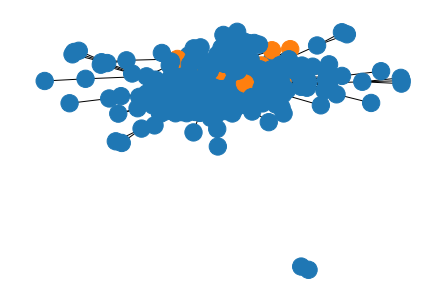

In [19]:
# Crtanje interaktoma nestrukturnih proteina
crtaj('../json/Nsp_iRef.json', Nsp_iref.ids)

I ovde je moguće napraviti interaktivnu mrežu, takođe uz napomenu o slaboj preglednosti prikaza, što je sada još izraženije.

In [20]:
# Crtanje interaktoma nestrukturnih proteina
pyvis('../json/Nsp_iRef.json')

Još jednom je moguće pokušati sa poboljšanjem preglednosti tako što se izbace polazni proteini i autointerakcije.

In [21]:
# Crtanje interaktoma nestrukturnih proteina
pyvis('../json/Nsp_iRef.json', Nsp_iref.ids)

Ista baza može se iskoristiti za pravljenje drugog interaktoma zasnovanog na membranskom proteinu, umesto prethodne *IntAct*.

In [22]:
# Novi pogled na M protein
M2 = Protein('P0DTC5', False)

# Novi interaktom M proteina
M_iref = Interaktom(M2)

# Čuvanje u JSON formatu
M_iref.sacuvaj('M_iRef')

,Broj suseda,Spisak suseda
A0A024R071,4,"[A0A024R071, P0DTC5, Q8WUM0, Q9BW27]"
A0A024R374,5,"[A0A024R374, P0DTC2, P0DTC5, XP_011517282, XP_..."
A0A024R3H9,1,[P0DTC5]
A0A024R3U8,8,"[A0A024R3U8, O75306, O75439, O75947, P0DTC5, X..."
A0A024R438,3,"[A0A024R438, P0DTC5, Q9UHD2]"
...,...,...
XP_016872628,1,[P0DTC5]
XP_016876117,2,"[P0DTC5, P25686]"
XP_016879599,1,[P0DTC5]
XP_016882939,1,[P0DTC5]


Ova mreža ima 211 čvorova, nešto manje od prethodnih 259, ali je takođe primetno povezanija. Ovo se u suštini može shvatiti kao značajniji rezultat u kontekstu dalje analize strukture grafa, a posledica je većeg obima posmatrane baze *iRefIndex*, što je, kako je već pomenuto, njena velika prednost.

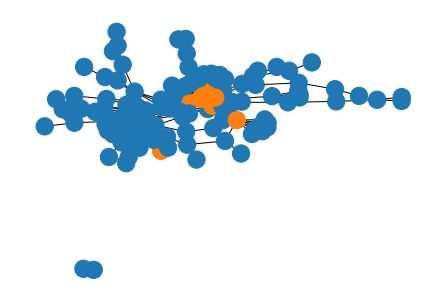

In [23]:
# Crtanje interaktoma M proteina
crtaj('../json/M_iRef.json', M_iref.ids)

Još jednom je moguće napraviti interaktivnu mrežu, takođe uz napomenu o slaboj preglednosti prikaza.

In [24]:
# Crtanje interaktoma M proteina
pyvis('../json/M_iRef.json')

Naravno, opet nije loše pokušati sa poboljšanjem preglednosti isključivanjem gustih čvorova iz prikaza.

In [25]:
# Crtanje interaktoma M proteina
pyvis('../json/M_iRef.json', M_iref.ids)

## 6. Virusni interaktom [⮭]<a id="par:virusni"></a>

[⮭]: #par:toc

Prethodni interaktomi sadržali su kako virusne, tako i ljudske proteine. Moguće je ograničiti se samo na virusne, što je u nastavku urađeno i ilustrovano.

In [26]:
# Svi proteini u klasi
SARS_proteom = {Protein(prot, False) for prot in SARS}

# Interaktom svih proteina
SARS_iref = Interaktom(SARS_proteom, SARS_proteom)

# Čuvanje u JSON formatu
SARS_iref.sacuvaj('SARS_iRef')

,Broj suseda,Spisak suseda
A0A663DJA2,4,"[A0A663DJA2, P0DTC3, P0DTC5, P0DTC9]"
P0DTC2,3,"[P0DTC2, P0DTC4, P0DTC5]"
P0DTC3,6,"[A0A663DJA2, P0DTC3, P0DTC4, P0DTC7, P0DTD8, Y..."
P0DTC4,5,"[P0DTC2, P0DTC3, P0DTC4, P0DTC9, P0DTD2]"
P0DTC5,7,"[A0A663DJA2, P0DTC2, P0DTC5, P0DTC6, P0DTC7, P..."
P0DTC6,5,"[P0DTC5, P0DTC6, P0DTC7, YP_009725299, YP_0097..."
P0DTC7,7,"[P0DTC3, P0DTC5, P0DTC6, P0DTC7, P0DTC9, P0DTD..."
P0DTC8,2,"[P0DTC8, YP_009725304]"
P0DTC9,6,"[A0A663DJA2, P0DTC4, P0DTC5, P0DTC7, P0DTC9, Y..."
P0DTD2,3,"[P0DTC4, P0DTC7, P0DTD2]"


Kao i dosad, pored tabelarnog prikaza, moguće je mrežu predstaviti i u pravom svetlu: kao sliku sa čvorovima i vezama.

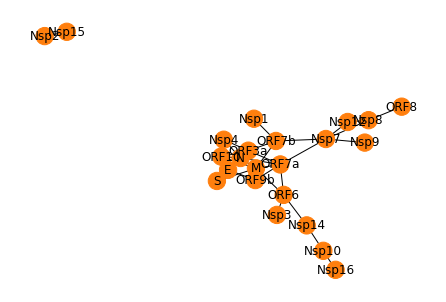

In [27]:
# Crtanje interaktoma nestrukturnih proteina
crtaj('../json/SARS_iRef.json', SARS)

Sada ima više smisla generisati i interaktivnu mrežu, jer u slučaju malog interaktoma nije previše gusta i nepregledna, pa se može lako analizirati. Glavna razlika je što boja ovde zavisi od tipa proteina, pošto su sada svakako svi virusni: strukturni su svetloplavi, nestrukturni narandžasti, a pomoćni ljubičasti.

In [28]:
# Određivanje boje prema tipu
def boja(prot):
    if SARS[prot].startswith('Nsp'):
        return '#f89868'
    elif SARS[prot].startswith('ORF'):
        return '#7392ca'
    else:
        return '#8bd4e3'

# Interaktivni interaktom
pyvis('../json/SARS_iRef.json')

Rezultate je moguće porediti sa nekim drugim interaktomom, npr. onim iz nastavka. Primetno je da su vrlo slični, mada postoje određene razlike.

<img src='../slike/SARS_Gao.png' width='75%'>

Naravno, moguće je formirati i celokupni interaktom virusa *SARS-CoV-2*, koji sadrži kako virusne, tako i sve povezane ljudske proteine.

In [29]:
# Celokupan interaktom SARS-CoV-2
SARS2_iref = Interaktom(SARS_proteom)

# Čuvanje u JSON formatu
SARS2_iref.sacuvaj('SARS2_iRef')

,Broj suseda,Spisak suseda
A0A024QYR3,13,"[A0A024R2K1, B7Z8M7, O15400-2, O75947, P0DTD8,..."
A0A024QYR8,4,"[A0A024RBV5, P0DTD8, Q9H1C4, XP_005269747]"
A0A024QYS2,6,"[A0A024R882, F2YGU2, P00533, P0DTD8, Q9H1C4, X..."
A0A024QYT5,6,"[A0A024QYT5, P00750, P0DTC8, Q96Q45, XP_005252..."
A0A024QYW3,16,"[A0A024QYW3, A0A024QYX0, O14684, P0DTC3, P0DTD..."
...,...,...
YP_009725307,24,"[A0A0S2Z4C3, A3KN83, O43823, O75592, O95391, Q..."
YP_009725308,41,"[A0A024R2W3, A0A024R712, A0A0A6YZ17, A4D0Z4, A..."
YP_009725309,8,"[A0A384N6C2, P06280, P0DTC6, Q86TG7, XP_005272..."
YP_009725310,9,"[A0A024R3X9, A0A024R6Y2, P62330, Q96HP0, Q9H4P..."


Usled velikog broja čvorova (čak 1419) i interakcija, ovaj interaktom nije vizuelizovan niti u vidu interaktivne mreže, niti u svojoj neinteraktivnoj verziji.

## 7. Neuređenost prema profilu [⮭]<a id="par:profil"></a>

[⮭]: #par:toc

Iako [*Composition Profiler*](http://www.cprofiler.org/cgi-bin/profiler.cgi) nema lep *API* za automatizovan rad, moguće je programatski ga oponašati. Ideja je uporediti udele aminokiselina sa referentnim udelima iz neke opšte i neke baze neuređenih proteina. Zapravo se za svaku aminokiselinu proverava da li je sekvenca obogaćena njome ili osiromašena. Ovom prilikom izračunato je pet različitih mera, koje će biti objašnjene u trenutku kada budu grafički prikazane u odnosu na stepen povezanosti.

In [30]:
# Referentni udeli aminokiselina
aa = ['A', 'N', 'C', 'Q', 'E', 'H', 'I', 'L', 'K' , 'M', 'F', 'P', 'S', 'W', 'Y', 'V']
pdb = [.0770, .0458, .0174, .0395, .0665, .0241, .0561, .0868,
       .0637, .0222, .0398, .0457, .0619, .0144, .0350, .0672]
dp = [.0810, .0382, .0080, .0527, .0989, .0193, .0324, .0622,
      .0785, .0187, .0244, .0811, .0865, .0067, .0213, .0541]

# Generisanje skupa 'neuređenih' kiselina
neur = {amino for amino, norm, dis in zip(aa, pdb, dp) if norm < dis}

# Aminokiselinski profil kao udeo neuređenih
def profil(self):
    try:
        # Pokušaj čitanja sa lokala
        with open(f'../profil/{self.idd()}.json', 'r') as f:
            prof = json.load(f)
        
        # Upisivanje vrednosti
        for prop in prof:
            setattr(self, prop, prof[prop])
    except:
        # Inicijalno prazan niz razlika
        razlike = [[], []]
        
        # Inicijalno nulti udeo prema uređenosti
        self.prof_ppidr = 0
        
        # Prolazak kroz svaku aminokiselinu
        for amino, norm, dis in zip(aa, pdb, dp):
            # Prebrojavanje tekuće kiseline
            tren = self.sekvenca.count(amino) / self.duzina
            
            # Dodavanje ako je 'neuređena'
            if norm < dis: self.prof_ppidr += tren
            
            # Provera kojoj grupi je udeo bliži
            razlike[0].append(abs(tren-norm) - abs(tren-dis))
            razlike[1].append(razlike[0][-1] > 0)
        
        # Uprosečavanje razlika (bliskosti)
        self.prof_hard = int(np.mean(razlike[0]) > 0)
        self.prof_soft = np.mean(razlike[1])
        
        # Inicijalizacija broja neuređenih regiona
        self.prof_reg5 = 0
        self.prof_reg31 = 0
        
        # Dužina tekućeg regiona
        i = 0
        
        # Brojanje neuređenih regiona u sekvenci
        for c in self.sekvenca:
            # Produžavanje neuređenog regiona
            if c in neur:
                i += 1
            else:
                # Regioni dužine makar pet
                if i >= 5:
                    self.prof_reg5 += 1
                
                # Regioni dužine preko trideset
                if i > 30:
                    self.prof_reg31 += 1
                
                # Kraj neuređenog regiona
                i = 0
        
        # Regioni dužine makar pet
        if i >= 5:
            self.prof_reg5 += 1
        
        # Regioni dužine preko trideset
        if i > 30:
            self.prof_reg31 += 1
        
        # Upisivanje na lokal za ubuduće
        with fopen(f'../profil/{self.idd()}.json', 'w') as f:
            json.dump({'prof_hard': self.prof_hard,
                       'prof_soft': self.prof_soft,
                       'prof_ppidr': self.prof_ppidr,
                       'prof_reg5': self.prof_reg5,
                       'prof_reg31': self.prof_reg31}, f)

# Postavljanje za metod klase
Protein.profil = profil

Još jednom je moguće grafički uporediti stepen povezanosti čvora sa prethodno izračunatim stepenima neuređenosti prema profilu. Svaka kolona predstavlja jedan interaktom, označen u zagradi naslova grafika. Svaki red, s druge strane, predstavlja jednu prikazanu meru. U konkretnom slučaju, prva mera je 'tvrdi' profil, koji zapravo predstavlja neotežani udeo (indikator bliskosti) aminokiselina u proteinu čija je raspodela bliža bazi neuređenih proteina *DisProt* nego opštoj bazi (skupu *PDB Select 25*). Druga mera je 'meki' profil, što je isti udeo, samo otežan tako da statistički značajnija obogaćenja i osiromašenja više doprinose rezultatu (sada je to realna vrednost, a ne indikator). Treća mera je jednostavan (neotežani) udeo aminokiselina koje su prisutnije u neuređenim proteinima. Po rezultatima se i ovoga puta čini da mreže izgledaju uobičajeno za jedan interaktom, ali se takođe ne primećuje jasna veza povezanosti sa neuređenošću.

In [31]:
# Prebacivanje novog reda na pravo mesto
def novi(sup):
    if '\n' in sup:
        return sup.replace('\n', '') + '\n'
    else: return sup

# Crtanje tekućeg poređenja
def crtaj(fja, n, sup, x=False, y=True):
    # Podela slike na više delova
    fig, axs = plt.subplots(n, 4,
                            figsize=(10, 3*n),
                            sharex=x, sharey=y)
    
    # Poređenje ili statistike
    a = fja(M_intact, 'M_IntAct', axs[0] if n == 1 else axs[:, 0])
    b = fja(M_iref, 'M_iRef', axs[1] if n == 1 else axs[:, 1])
    c = fja(Nsp_iref, 'Nsp_iRef', axs[2] if n == 1 else axs[:, 2])
    d = fja(SARS2_iref, 'SARS2_iRef', axs[3] if n == 1 else axs[:, 3])
    
    # Ukoliko ime već nije kompletno
    if '–' not in sup:
        # Određivanje dodatka na ime
        dodatak = 'zajednička' if fja == poredi else 'uslovna'
        
        # Lepljenje određenog dodatka
        sup = sup + f' – {dodatak} raspodela'
    
    # Čuvanje i crtanje slike
    oslobodi(fig, novi(sup))
    
    # Vraćanje izračunatih mera
    if a is not None:
        return a, b, c, d

# Poređenje prema profilu
def poredi(interakt, ime, axs):
    # Inicijalno prazne liste koordinata
    X, Y, Z = [], [[], [], []], []

    # Prolazak kroz sve proteine
    for prot in interakt.prots:
        # Određivanje profila
        prot.profil()
        
        # Preskakanje polaznih
        if prot.id in interakt.ids:
            continue

        # Novi stepen povezanosti
        X.append(prot.susedi)
        
        # Novi podatak o poreklu proteina
        Z.append(prot.ljudski)

        # Nove mere prema profilu
        Y[0].append(prot.prof_hard)
        Y[1].append(prot.prof_soft)
        Y[2].append(prot.prof_ppidr)
    
    # Indikator tekućeg interaktoma
    global intind
    intind = ime
    
    # Crtanje mera prema profilu
    plotuj(X, Y[0], Z, axs[0], f'Stepen naspram\ntvrdog profila ({ime})')
    plotuj(X, Y[1], Z, axs[1], f'Stepen naspram\nmekog profila ({ime})')
    plotuj(X, Y[2], Z, axs[2], f'Stepen naspram\nudela neuređenih ({ime})')
    
    # Vraćanje izračunatih mera
    return X, Y

# Poređenje prema profilu
P = crtaj(poredi, 3, 'Aminokiselinski profil')

I ovde su prikazani srednja vrednost i standardno odstupanje uslovne raspodele neuređenosti proteina prema stepenu povezanosti čvora. Kao značajan rezultat izdvaja se udeo aminokiselina prisutnijih u neuređenim proteinima. Naime, ova mera relativno stabilno raste zajedno sa porastom stepena povezanosti otprilike do stepena deset (prema membranskom proteinu), dvadeset (prema nestrukturnim proteinima) ili pedeset (prema svim). Nakon toga sledi nagli pad. Statistički gledano, prema tome se čini da je zajednička raspodela povezanosti i neuređenosti negativno asimetrična. Ova mera je, takođe, prilično stabilna (slabo varijabilna), što se vidi po niskom standardnom odstupanju, pa je time automatski najpogodnija za zaključivanje o odnosu raspodela.

In [32]:
# Statistike prema profilu
crtaj(statistike, 3, 'Aminokiselinski profil')

Još jednom su ispitani kvadranti, ali ovoga puta nije moguće izvesti konkretan zaključak, budući da su proseci veoma bliski, a ponegde i jednaki.

In [33]:
# Stubići sa prosecima tekućeg interaktoma
def barint(X, Y, ax, ime):
    prosek(X, Y[0], ax[0], f'Stepen naspram\ntvrdog profila ({ime})')
    prosek(X, Y[1], ax[1], f'Stepen naspram\nmekog profila ({ime})')
    prosek(X, Y[2], ax[2], f'Stepen naspram\nudela neuređenih ({ime})')
    
# Stubići sa prosečnom neuređenošću
def barplot(P, sup, x=False, y=True):
    # Broj redova u grafiku
    n = len(P[0][1])
    
    # Podela slike na više delova
    fig, axs = plt.subplots(n, 4,
                            figsize=(10, 3*n),
                            sharex=x, sharey=y)
    
    # Stubići sa prosecima svih interaktoma    
    barint(*P[0], axs[0] if n == 1 else axs[:, 0], 'M_IntAct')
    barint(*P[1], axs[1] if n == 1 else axs[:, 1], 'M_iRef')
    barint(*P[2], axs[2] if n == 1 else axs[:, 2], 'Nsp_iRef')
    barint(*P[3], axs[3] if n == 1 else axs[:, 3], 'SARS2_iRef')
    
    # Čuvanje i crtanje slike
    oslobodi(fig, novi(sup + ' – proseci po podeli'))

# Stubići sa prosečnom neuređenošću
barplot(P, 'Aminokiselinski profil')

U nastavku je prikazana raspodela aminokiselinskih profila kao pojedinačne slučajne promenljive. Histogrami su prilično pravilnih oblika.

In [34]:
# Histogrami sa raspodelom tekućeg interaktoma
def histint(X, Y, ax, ime):
    histoidp(X, Y[0], ax[0], f'Raspodela tvrdog\nprofila ({ime})')
    histoidp(X, Y[1], ax[1], f'Raspodela mekog\nprofila ({ime})')
    histoidp(X, Y[2], ax[2], f'Raspodela udela\nneuređenih ({ime})')

# Histogrami sa raspodelom neuređenosti
def raspodela(P, sup, x=True, y=False):
    # Broj redova u grafiku
    n = len(P[0][1])
    
    # Podela slike na više delova
    fig, axs = plt.subplots(n, 4,
                            figsize=(10, 3*n),
                            sharex=x, sharey=y)
    
    # Raspodela neuređenosti svih interaktoma    
    histint(P[0][0], P[0][1], axs[0] if n == 1 else axs[:, 0], 'M_IntAct')
    histint(P[1][0], P[1][1], axs[1] if n == 1 else axs[:, 1], 'M_iRef')
    histint(P[2][0], P[2][1], axs[2] if n == 1 else axs[:, 2], 'Nsp_iRef')
    histint(P[3][0], P[3][1], axs[3] if n == 1 else axs[:, 3], 'SARS2_iRef')
    
    # Čuvanje i crtanje slike
    oslobodi(fig, novi(sup + ' – pojedinačna raspodela'))

# Histogrami sa raspodelom neuređenosti
raspodela(P, 'Aminokiselinski profil')

## 8. Neuređenost prema *PONDR* [⮭]<a id="par:pondr"></a>

[⮭]: #par:toc

Iako ni [*PONDR*](http://www.pondr.com/) nema lep *API* za automatizovan rad, moguće je programatski oponašati ručno dohvatanje rezultata preko formulara. Sada je manipulacijom *HTTP* zahtevima preuzeto deset različitih mera, koje će biti objašnjene u trenutku kada budu grafički prikazane u odnosu na stepen povezanosti.

In [35]:
# Biblioteka za lepo formatiranje
import bs4

# Biblioteka za rad sa formularima
import mechanize

# Aktivni veb-pregledač (brauzer)
br = mechanize.Browser()

# Informacije o PONDR prediktoru
def _pondr(odgovor):
    # Udeo neuređenih i prosek skora
    pondr = re.search(r'Overall percent disordered: (.*?)\t'
                      r'Average Prediction Score: (.*?)\n', odgovor)
    
    # Dohvatanje grupa regularnog izraza
    if pondr: pondr = pondr.groups()
    # Prekratke sekvence su obično uređene
    else: return 0, 0, 0, 0
    
    # Upisivanje izračunatih vrednosti
    mean = float(pondr[1])
    ppidr = float(pondr[0]) / 100
    
    # Inicijalizacija broja neuređenih regiona
    reg5, reg31 = 0, 0
    
    # Informacije o neuređenim regionima
    for i, j in re.findall(r'Predicted disorder segment \[(\d+)]-\[(\d+)]', odgovor):
        # Dužina neuređenog regiona
        reg = int(j) - int(i) + 1
        
        # Regioni dužine makar pet
        if reg >= 5:
            reg5 += 1
            
        # Regioni dužine preko trideset
        if reg > 30:
            reg31 += 1
    
    # Vraćanje izračunatih vrednosti
    return mean, ppidr, reg5, reg31

# Upotreba PONDR prediktora neuređenosti
def pondr(self):
    try:
        # Pokušaj čitanja sa lokala
        with open(f'../pondr/{self.idd()}.json', 'r') as f:
            pondrs = json.load(f)
        
        # Upisivanje vrednosti
        for prop in pondrs:
            setattr(self, prop, pondrs[prop])
    except:
        # PONDR veb-stranica
        br.open('http://www.pondr.com/')
        
        # Formular za zahtev
        br.select_form(nr=1)
        
        # Označen VSL2 prediktor
        br['VSL2'] = ['on']
        
        # Označena hidropatija
        br['CH'] = ['on']
        
        # Idektifikator proteina
        br['AccessionCode'] = self.id
        
        # Sekvenca proteina
        br['Sequence'] = self.fasta.replace('U', '')
        
        # Rezultat PONDR zahteva
        odgovor = bs4.BeautifulSoup(br.submit().read(),
                                    features='html5lib').prettify()
        
        # Granica VLXT i VSL2 prediktora
        granica = odgovor.find('=VSL2')
        
        # Informacije o VLXT prediktoru
        self.vlxt_mean, self.vlxt_ppidr,\
        self.vlxt_reg5, self.vlxt_reg31 = _pondr(odgovor[:granica])
        
        # Informacije o VSL2 prediktoru
        self.vsl2_mean, self.vsl2_ppidr,\
        self.vsl2_reg5, self.vsl2_reg31 = _pondr(odgovor[granica:])
        
        # Informacije o hidropatiji
        ch = re.search(r'Hydropathy: (.*?)\t'
                       r'Boundary Hydropathy=(.*?)\n', odgovor)
        
        # Dohvatanje grupa regularnog izraza
        if ch: ch = ch.groups()
        # Prekratke sekvence su obično uređene
        else: ch = 1, .5
        
        # Upisivanje vrednosti
        self.ch_val = float(ch[0])
        self.ch_ind = int(float(ch[0]) < float(ch[1]))
        
        # Upisivanje na lokal za ubuduće
        with fopen(f'../pondr/{self.idd()}.json', 'w') as f:
            json.dump({'vlxt_mean': self.vlxt_mean,
                       'vlxt_ppidr': self.vlxt_ppidr,
                       'vsl2_mean': self.vsl2_mean,
                       'vsl2_ppidr': self.vsl2_ppidr,
                       'ch_val': self.ch_val,
                       'ch_ind': self.ch_ind,
                       'vlxt_reg5': self.vlxt_reg5,
                       'vlxt_reg31': self.vlxt_reg31,
                       'vsl2_reg5': self.vsl2_reg5,
                       'vsl2_reg31': self.vsl2_reg31}, f)

# Postavljanje za metod klase
Protein.pondr = pondr

I ovde se grafički poredi stepen povezanosti čvora sa prethodno izračunatim *PONDR* skorovima. Prva mera jeste prosečan *VLXT* skor po aminokiselini, dok je druga udeo *VLXT* skorova većih od praga 0,5. Ovaj prediktor zapravo integriše tri nepovratne (*feedforward*) neuronske mreže: *VL1*, *XN* i *XC*, koje su trenirane nad podacima dobijenim rendgenskom kristalografijom. Prolazom kroz aminokiselinski niz, prediktor svakom ostatku dodeljuje ocenu neuređenosti.

In [36]:
# Poređenje prema PONDR skorovima
def poredi(interakt, ime, axs):
    # Inicijalno prazne liste koordinata
    X, Y, Z = [], [[], []], []

    # Prolazak kroz sve proteine
    for prot in interakt.prots:
        # Određivanje PONDR skorova
        prot.pondr()
        
        # Preskakanje polaznih
        if prot.id in interakt.ids:
            continue

        # Novi stepen povezanosti
        X.append(prot.susedi)
        
        # Novi podatak o poreklu proteina
        Z.append(prot.ljudski)

        # Nove mere prema PONDR skorovima
        Y[0].append(prot.vlxt_mean)
        Y[1].append(prot.vlxt_ppidr)
    
    # Indikator tekućeg interaktoma
    global intind
    intind = ime
    
    # Crtanje mera prema PONDR
    plotuj(X, Y[0], Z, axs[0], f'Stepen naspram\nVLXT proseka ({ime})')
    plotuj(X, Y[1], Z, axs[1], f'Stepen naspram\nVLXT udela ({ime})')
    
    # Vraćanje izračunatih mera
    return X, Y

# Poređenje prema PONDR skorovima
P = crtaj(poredi, 2, 'PONDR® VLXT')

Takođe su ilustrovane osnovne statistike uslovne raspodele neuređenosti proteina prema stepenu povezanosti čvora.

In [37]:
# Statistike prema PONDR skorovima
crtaj(statistike, 2, 'PONDR® VLXT')

Takođe su prikazani stubići sa prosecima po kvadrantima. I ovoga puta su proseci previše bliski da bi se izveo neki konkretan zaključak.

In [38]:
# Stubići sa prosecima tekućeg interaktoma
def barint(X, Y, ax, ime):
    prosek(X, Y[0], ax[0], f'Stepen naspram\nVLXT proseka ({ime})')
    prosek(X, Y[1], ax[1], f'Stepen naspram\nVLXT udela ({ime})')

# Stubići sa prosečnom neuređenošću
barplot(P, 'PONDR® VLXT')

Takođe su prikazani histogrami sa raspodelom neuređenosti. I ovoga puta imaju vrlo pravilan oblik.

In [39]:
# Histogrami sa raspodelom tekućeg interaktoma
def histint(X, Y, ax, ime):
    histoidp(X, Y[0], ax[0], f'Raspodela VLXT\nproseka ({ime})')
    histoidp(X, Y[1], ax[1], f'Raspodela VLXT\nudela ({ime})')

# Histogrami sa raspodelom neuređenosti
raspodela(P, 'PONDR® VLXT')

U nastavku je prikazan prosečan *VSL2* skor po aminokiselini, kao i udeo *VSL2* skorova većih od praga 0,5. Ovaj prediktor integriše dve neuronske mreže: jednu za kraće, drugu za duže neuređene regione. Konačni rezultat je otežani prosek skorova. Ovo je najtačniji pojedinačni model iz *PONDR* familije. Rezultati veoma liče na one dobijene pomoću modela *VLXT*, s tim što su sve neuređenosti nešto više (kružići su pomereni nagore) i raspršenije (veća disperzija).

In [40]:
# Poređenje prema PONDR skorovima
def poredi(interakt, ime, axs):
    # Inicijalno prazne liste koordinata
    X, Y, Z = [], [[], []], []

    # Prolazak kroz sve proteine
    for prot in interakt.prots:
        # Određivanje PONDR skorova
        prot.pondr()
        
        # Preskakanje polaznih
        if prot.id in interakt.ids:
            continue

        # Novi stepen povezanosti
        X.append(prot.susedi)
        
        # Novi podatak o poreklu proteina
        Z.append(prot.ljudski)

        # Nove mere prema PONDR skorovima
        Y[0].append(prot.vsl2_mean)
        Y[1].append(prot.vsl2_ppidr)
    
    # Indikator tekućeg interaktoma
    global intind
    intind = ime
    
    # Crtanje mera prema PONDR
    plotuj(X, Y[0], Z, axs[0], f'Stepen naspram\nVSL2 proseka ({ime})')
    plotuj(X, Y[1], Z, axs[1], f'Stepen naspram\nVSL2 udela ({ime})')
    
    # Vraćanje izračunatih mera
    return X, Y

# Poređenje prema PONDR skorovima
P = crtaj(poredi, 2, 'PONDR® VSL2')

Takođe su ilustrovane osnovne statistike uslovne raspodele neuređenosti proteina prema stepenu povezanosti čvora.

In [41]:
# Statistike prema PONDR skorovima
crtaj(statistike, 2, 'PONDR® VSL2')

Takođe su ilustrovani proseci povezanosti i neuređenosti po polovinama grafika.

In [42]:
# Stubići sa prosecima tekućeg interaktoma
def barint(X, Y, ax, ime):
    prosek(X, Y[0], ax[0], f'Stepen naspram\nVSL2 proseka ({ime})')
    prosek(X, Y[1], ax[1], f'Stepen naspram\nVSL2 udela ({ime})')

# Stubići sa prosečnom neuređenošću
barplot(P, 'PONDR® VSL2')

Takođe su mere neuređenosti ilustrovane pomoću histograma vrlo pravilnih oblika.

In [43]:
# Histogrami sa raspodelom tekućeg interaktoma
def histint(X, Y, ax, ime):
    histoidp(X, Y[0], ax[0], f'Raspodela\nVSL2 proseka ({ime})')
    histoidp(X, Y[1], ax[1], f'Raspodela\nVSL2 udela ({ime})')

# Histogrami sa raspodelom neuređenosti
raspodela(P, 'PONDR® VSL2')

Sledeća prikazana mera jeste hidropatija, koja apstrahuje kompaktnost proteina. Činjenica je da hidrofobniji proteini, dakle oni sa većom hidropatijom, imaju čvršću strukturu, što znači da su stabilniji, a samim tim i uređeniji. Poslednja mera jeste rezultat *CH* (*charge-hydropathy*) predikcije, koja predviđa neuređenost proteina na osnovu kombinacije hidropatije i srednjeg naelektrisanja, koje je takođe važno, jer su naelektrisaniji proteini mahom nestabilniji.

In [44]:
# Poređenje prema PONDR skorovima
def poredi(interakt, ime, axs):
    # Inicijalno prazne liste koordinata
    X, Y, Z = [], [[], []], []

    # Prolazak kroz sve proteine
    for prot in interakt.prots:
        # Određivanje PONDR skorova
        prot.pondr()
        
        # Preskakanje polaznih
        if prot.id in interakt.ids:
            continue

        # Novi stepen povezanosti
        X.append(prot.susedi)
        
        # Novi podatak o poreklu proteina
        Z.append(prot.ljudski)

        # Nove mere prema PONDR skorovima
        Y[0].append(prot.ch_val)
        Y[1].append(prot.ch_ind)
    
    # Indikator tekućeg interaktoma
    global intind
    intind = ime
    
    # Crtanje mera prema PONDR
    plotuj(X, Y[0], Z, axs[0], f'Stepen naspram\nhidropatije ({ime})')
    plotuj(X, Y[1], Z, axs[1], f'Stepen naspram\nCH predikcije ({ime})')
    
    # Vraćanje izračunatih mera
    return X, Y

# Poređenje prema PONDR skorovima
P = crtaj(poredi, 2, 'Hidropatija i CH')

Dodatni prikaz statistika uslovne raspodele ovde je posebno važan. Naime, u slučaju *CH* predikcije, koja uzima samo vrednosti jedan i nula, bez ovog dodatka nije moguće lako videti kolika je u globalu neuređenost posmatrane grupe po povezanosti. Standardno odstupanje te mere je, stoga, prilično veliko. Prema njoj se još jednom čini nešto što je već ranije primećeno: prosečna neuređenost raste otprilike do stepena deset, dvadeset, pedeset, nakon čega fluktuira.

In [45]:
# Statistike prema PONDR skorovima
crtaj(statistike, 2, 'Hidropatija i CH')

U nastavku su prikazani proseci po kvadrantima. Primetan je veći prosek *CH* prediktora na levom delu.

In [46]:
# Stubići sa prosecima tekućeg interaktoma
def barint(X, Y, ax, ime):
    prosek(X, Y[0], ax[0], f'Stepen naspram\nhidropatije ({ime})')
    prosek(X, Y[1], ax[1], f'Stepen naspram\nCH predikcije ({ime})')

# Stubići sa prosečnom neuređenošću
barplot(P, 'Hidropatija i CH')

Takođe su prikazani histogrami sa raspodelom neuređenosti. I ovoga puta imaju sasvim karakterističan oblik.

In [47]:
# Histogrami sa raspodelom tekućeg interaktoma
def histint(X, Y, ax, ime):
    histoidp(X, Y[0], ax[0], f'Raspodela\nhidropatije ({ime})')
    histoidp(X, Y[1], ax[1], f'Raspodela CH\npredikcije ({ime})')

# Histogrami sa raspodelom neuređenosti
raspodela(P, 'Hidropatija i CH')

Po svim izloženim rezultatima još jednom se primećuje nelinearna veza stepena čvora sa neuređenosti predstavljenog proteina. Za pojedine mere se čini da rastu do određenog stepena povezanosti, a zatim naglo opadaju. Ova osobina zapravo je povezana sa odabirom granica kvadranata i može se grafički predstaviti kao u nastavku. Prikazan je odnos razmatrane mere (povezanost ili *VSL2* udeo) i očekivanog 'dobitka' na osnovu mesta podele grafika. Uočava se postojanje lokalnih minimuma u stepenima $5$, $10$, $21$, $47$. Prihvatljiva aproksimacija toga jeste kvantil $0.982$: on daje stepene $12$ (povoljniji od $5$), $12.48$ (manje povoljan od $10$), $25.38$ (podjednako povoljan kao $21$) i $47$ (pogođen optimum). Postoji, dakle, jako opravdanje za odabir kvantila kao horizontalne granice. Nema značajnog dobitka po pitanju stepena prema *VSL2* udelu, tako da je tu u redu odabrati $0.3$ kao opštu granicu neuređenosti iz literature. Ova granica dodatno je zanimljiva, budući bliska kvantilu $0.5$, dakle medijani. Drugim rečima, ona deli podatke na dva dela približno jednakih veličina.

In [48]:
# Spisak svih interaktoma
imena = 'M_IntAct', 'M_iRef', 'Nsp_iRef', 'SARS2_iRef'
interakts = M_intact, M_iref, Nsp_iref, SARS2_iref

# Mapiranje [0, 1, inf) ↦ [0, .5, 1]
def mapiraj(l, d):
    return d / (d + l)

# Određivanje pojedinačnog 'dobitka'
def pojdob(X, Y, i, j):
    # Elementi sa obe strane granice
    l = Y[X <= i]
    d = Y[X > j]
    
    # Preskakanje praznih podela
    if not l.size or not d.size:
        return None
    
    # Neuređenost sa obe strane granice
    l = np.mean(l)
    d = np.mean(d)
    
    # 'Dobitak' pri podeli na tom mestu
    return mapiraj(l, d)

# Ucrtavanje svih 'dobitaka' po osi
def dobitak(X, Y, Xuniq, Xsred, ime, ax):
    # Inicijalizacija praznih nizova
    x, y = [], []
    
    # Prolazak kroz sve stepene i mere
    for i in Xuniq:
        # 'Dobitak' pri podeli na tom mestu
        dob = pojdob(X, Y, i, i)
        
        # Preskakanje praznih podela
        if dob is None: continue
        
        # Tekući stepen ili mera
        x.append(i)
        
        # 'Dobitak' pri podeli na tom mestu
        y.append(dob)
    
    # Ucrtavanje grafika 'dobitaka'
    ax.plot(x, y, color='rebeccapurple')
    
    # Označavanje odabrane granice
    ax.axvline(Xsred, ls=':', color='black', alpha=.75)
    
    # Označavanje nultog 'dobitka'
    ax.axhline(.5, ls=':', color='black', alpha=.75)
    
    # Postavljanje naziva grafika
    ax.set_title(ime, fontsize=10)

# Podela slike na više delova
fig, axs = plt.subplots(2, 4, figsize=(10, 6))

# Spajanje osa grafika po redovima
for i in range(2):
    for j in range(3):
        axs[i, j].sharey(axs[i, j+1])

# Prolazak kroz sve interaktome
for i, (ime, interakt) in enumerate(zip(imena, interakts)):
    # Povezanost tekućeg interaktoma
    X = np.array([p.susedi for p in interakt.prots if p.id not in interakt.ids])
    
    # Neuređenost tekućeg interaktoma
    Y = np.array([p.vsl2_ppidr for p in interakt.prots if p.id not in interakt.ids])
    
    # Ucrtavanje dobitka na meri po stepenu
    dobitak(X, Y, np.unique(X), np.quantile(X, .982),
            f'Dobitak na VSL2 meri\npo stepenu ({ime})', axs[0, i])
    
    # Ucrtavanje dobitka na stepenu po meri
    dobitak(Y, X, np.linspace(0, 1, 20), .3,
            f'Dobitak na stepenu\npo VSL2 meri ({ime})', axs[1, i])

# Čuvanje i crtanje slike
oslobodi(fig, f'Raspodela dobitaka prema mestu podele grafika (2D)')

Slično je moguće uraditi i ako podele nisu u istoj tački, s tim što je tada neophodan trodimenzionalni prikaz ili mapiranje dobitka u boju, kao u nastavku.

In [49]:
# Podela slike na više delova
fig, axs = plt.subplots(2, 4, figsize=(10, 6))

# Ucrtavanje svih 'dobitaka' po osi
def dobitak(X, Y, Xuniq, Xsred, ime, ax):
    # Inicijalizacija praznih nizova
    x, y, z = [], [], []
    
    # Prolazak kroz sve stepene i mere
    for i in Xuniq:
        # Inicijalizacija praznih redova
        if not z or z[-1]:
            x.append([])
            y.append([])
            z.append([])
        
        # Prolazak kroz sve stepene i mere
        for j in Xuniq:
            # 'Dobitak' pri podeli na tom mestu
            dob = pojdob(X, Y, i, j)

            # Preskakanje praznih podela
            if dob is None: continue

            # Tekući stepen ili mera
            x[-1].append(i)
            y[-1].append(j)
            
            # 'Dobitak' pri podeli na tom mestu
            z[-1].append(dob)
    
    # Ucrtavanje grafika 'dobitaka'
    c = ax.contourf(x, y, z, levels=[.3, .4, .5, .6, .7])
    
    # Dodavanje stubića sa bojama
    fig.colorbar(c, ax=ax)
    
    # Dohvatanje granica prikaza
    levo, desno = ax.get_xlim()
    dole, gore = ax.get_ylim()
    
    # Određivanje novih granica
    granice = max(levo, dole), min(desno, gore)
    
    # Označavanje odabrane granice
    ax.plot(Xsred, Xsred, '.', color='black')
    
    # Označavanje nultog 'dobitka'
    ax.plot([min(X), max(X)],
            [min(X), max(X)], ':', color='black', alpha=.75)
    
    # Vraćanje granica prikaza
    ax.set_xlim(granice)
    ax.set_ylim(granice)
    
    # Postavljanje naziva grafika
    ax.set_title(ime, fontsize=10)

# Prolazak kroz sve interaktome
for i, (ime, interakt) in enumerate(zip(imena, interakts)):
    # Povezanost tekućeg interaktoma
    X = np.array([p.susedi for p in interakt.prots if p.id not in interakt.ids])
    
    # Neuređenost tekućeg interaktoma
    Y = np.array([p.vsl2_ppidr for p in interakt.prots if p.id not in interakt.ids])
    
    # Ucrtavanje dobitka na meri po stepenu
    dobitak(X, Y, np.unique(X), np.quantile(X, .982),
            f'Dobitak na VSL2 meri\npo stepenu ({ime})', axs[0, i])
    
    # Ucrtavanje dobitka na stepenu po meri
    dobitak(Y, X, np.linspace(0, 1, 20), .3,
            f'Dobitak na stepenu\npo VSL2 meri ({ime})', axs[1, i])

# Čuvanje i crtanje slike
oslobodi(fig, f'Raspodela dobitaka prema mestu podele grafika (3D)')

## 9. Dužina neuređenih regiona [⮭]<a id="par:regioni"></a>

[⮭]: #par:toc

Neuređenost proteina može se meriti i prema broju dugačkih *IDR* (neuređeni regioni), koji podrazumevaju grupe susednih neuređenih aminokiselina. Eksperimentalno su značajni kratki neuređeni regioni dužine ne manje od pet, dok su još značajni oni dužine veće od trideset. Broj ovakvih regiona izračunat je prema profilu u jednom od prethodnih koraka, a sada dolazi na red grafički prikaz ovih mera. Neuređenim regionima ovde se smatraju nizovi uzastopnih aminokiselina statistički prisutnijih u neuređenim proteinima. Prikazan je i udeo regiona dužih od trideset u svim regionima dužine makar pet.

In [50]:
# Poređenje prema PONDR skorovima
def poredi(interakt, ime, axs):
    # Inicijalno prazne liste koordinata
    X, Y, Z = [], [[]], []

    # Prolazak kroz sve proteine
    for prot in interakt.prots:
        # Preskakanje polaznih
        if prot.id in interakt.ids:
            continue

        # Novi stepen povezanosti
        X.append(prot.susedi)
        
        # Novi podatak o poreklu proteina
        Z.append(prot.ljudski)

        # Nove dužine neuređenih regiona
        Y[0].append(prot.prof_reg5)
    
    # Indikator tekućeg interaktoma
    global intind
    intind = ime
    
    # Crtanje mera prema regionima
    plotuj(X, Y[0], Z, axs, f'Stepen naspram\nprof. regiona >=5 ({ime})')
    
    # Vraćanje izračunatih mera
    return X, Y

# Poređenje prema dužini regiona
P = crtaj(poredi, 1, 'Profilni neuređeni regioni', y=False)

U nastavku su prikazani srednja vrednost i standardno odstupanje uslovne raspodele neuređenosti proteina prema stepenu povezanosti čvora.

In [51]:
# Statistike prema dužini regiona
crtaj(statistike, 1, 'Profilni neuređeni regioni', y=False)

Prikazani su i stubići sa prosecima po delovima dijagrama.

In [52]:
# Stubići sa prosecima tekućeg interaktoma
def barint(X, Y, ax, ime):
    prosek(X, Y[0], ax, f'Stepen naspram\nprof. regiona >=5 ({ime})')

# Stubići sa prosečnom neuređenošću
barplot(P, 'Profilni neuređeni regioni')

Prikazani su i histogrami sa raspodelom brojeva regiona.

In [53]:
# Histogrami sa raspodelom tekućeg interaktoma
def histint(X, Y, ax, ime):
    histoidp(X, Y[0], ax, f'Raspodela prof.\nregiona >=5 ({ime})')

# Histogrami sa raspodelom neuređenosti
raspodela(P, 'Profilni neuređeni regioni')

Broj ovakvih regiona izračunat je i prema prediktoru *VLXT*. Ovde se neuređenim regionima smatraju nizovi uzastopnih aminokiselina sa vrednošću prediktora većom od polovine. Prema ovom modelu, donekle se čini da slabije povezani proteini imaju veći broj neuređenih regiona, mada nije sasvim izraženo.

In [54]:
# Poređenje prema PONDR skorovima
def poredi(interakt, ime, axs):
    # Inicijalno prazne liste koordinata
    X, Y, Z = [], [[], [], []], []

    # Prolazak kroz sve proteine
    for prot in interakt.prots:
        # Preskakanje polaznih
        if prot.id in interakt.ids:
            continue

        # Novi stepen povezanosti
        X.append(prot.susedi)
        
        # Novi podatak o poreklu proteina
        Z.append(prot.ljudski)

        # Nove dužine neuređenih regiona
        Y[0].append(prot.vlxt_reg5)
        Y[1].append(prot.vlxt_reg31)
        Y[2].append(Y[1][-1] / Y[0][-1] if Y[0][-1] else 0)
    
    # Indikator tekućeg interaktoma
    global intind
    intind = ime
    
    # Crtanje mera prema regionima
    plotuj(X, Y[0], Z, axs[0], f'Stepen naspram\nVLXT regiona >=5 ({ime})')
    plotuj(X, Y[1], Z, axs[1], f'Stepen naspram\nVLXT regiona >30 ({ime})')
    plotuj(X, Y[2], Z, axs[2], f'Stepen naspram\nodnosa VLXT regiona ({ime})')
    
    # Vraćanje izračunatih mera
    return X, Y

# Poređenje prema PONDR skorovima
P = crtaj(poredi, 3, 'VLXT neuređeni regioni', y=False)

U nastavku su prikazani srednja vrednost i standardno odstupanje uslovne raspodele neuređenosti proteina prema stepenu povezanosti čvora.

In [55]:
# Statistike prema dužini regiona
crtaj(statistike, 3, 'VLXT neuređeni regioni', y=False)

Još jednom su prikazani i stubići sa prosecima mera neuređenosti.

In [56]:
# Stubići sa prosecima tekućeg interaktoma
def barint(X, Y, ax, ime):
    prosek(X, Y[0], ax[0], f'Stepen naspram\nVLXT regiona >=5 ({ime})')
    prosek(X, Y[1], ax[1], f'Stepen naspram\nVLXT regiona >30 ({ime})')
    prosek(X, Y[2], ax[2], f'Stepen naspram\nodnosa VLXT regiona ({ime})')

# Stubići sa prosečnom neuređenošću
barplot(P, 'VLXT neuređeni regioni')

Još jednom su prikazani i histogrami pojedinačnih mera neuređenosti.

In [57]:
# Histogrami sa raspodelom tekućeg interaktoma
def histint(X, Y, ax, ime):
    histoidp(X, Y[0], ax[0], f'Raspodela VLXT\nregiona >=5 ({ime})')
    histoidp(X, Y[1], ax[1], f'Raspodela VLXT\nregiona >30 ({ime})')
    histoidp(X, Y[2], ax[2], f'Raspodela odnosa\nVLXT regiona ({ime})')

# Histogrami sa raspodelom neuređenosti
raspodela(P, 'VLXT neuređeni regioni', x=False)

Broj ovakvih regiona izračunat je i prema prediktoru *VSL2*, sa rezultatima i zaključcima istim kao kod *VLXT*.

In [58]:
# Poređenje prema PONDR skorovima
def poredi(interakt, ime, axs):
    # Inicijalno prazne liste koordinata
    X, Y, Z = [], [[], [], []], []

    # Prolazak kroz sve proteine
    for prot in interakt.prots:
        # Preskakanje polaznih
        if prot.id in interakt.ids:
            continue

        # Novi stepen povezanosti
        X.append(prot.susedi)
        
        # Novi podatak o poreklu proteina
        Z.append(prot.ljudski)

        # Nove dužine neuređenih regiona
        Y[0].append(prot.vsl2_reg5)
        Y[1].append(prot.vsl2_reg31)
        Y[2].append(Y[1][-1] / Y[0][-1] if Y[0][-1] else 0)
    
    # Indikator tekućeg interaktoma
    global intind
    intind = ime
    
    # Crtanje mera prema regionima
    plotuj(X, Y[0], Z, axs[0], f'Stepen naspram\nVSL2 regiona >=5 ({ime})')
    plotuj(X, Y[1], Z, axs[1], f'Stepen naspram\nVSL2 regiona >30 ({ime})')
    plotuj(X, Y[2], Z, axs[2], f'Stepen naspram\nodnosa VSL2 regiona ({ime})')
    
    # Vraćanje izračunatih mera
    return X, Y

# Poređenje prema PONDR skorovima
P = crtaj(poredi, 3, 'VSL2 neuređeni regioni', y=False)

U nastavku su prikazani srednja vrednost i standardno odstupanje uslovne raspodele neuređenosti proteina prema stepenu povezanosti čvora. Još jednom se čini da u interaktomu prema nestrukturnim proteinima prosek neuređenosti donekle raste uz porast stepena povezanosti, nakon čega naglo opada.

In [59]:
# Statistike prema dužini regiona
crtaj(statistike, 3, 'VSL2 neuređeni regioni', y=False)

Prikazani su i stubići sa prosecima po delovima dijagrama.

In [60]:
# Stubići sa prosecima tekućeg interaktoma
def barint(X, Y, ax, ime):
    prosek(X, Y[0], ax[0], f'Stepen naspram\nVSL2 regiona >=5 ({ime})')
    prosek(X, Y[1], ax[1], f'Stepen naspram\nVSL2 regiona >30 ({ime})')
    prosek(X, Y[2], ax[2], f'Stepen naspram\nodnosa VSL2 regiona ({ime})')

# Stubići sa prosečnom neuređenošću
barplot(P, 'VSL2 neuređeni regioni')

Prikazani su i histogrami sa raspodelom brojeva regiona.

In [61]:
# Histogrami sa raspodelom tekućeg interaktoma
def histint(X, Y, ax, ime):
    histoidp(X, Y[0], ax[0], f'Raspodela VSL2\nregiona >=5 ({ime})')
    histoidp(X, Y[1], ax[1], f'Raspodela VSL2\nregiona >30 ({ime})')
    histoidp(X, Y[2], ax[2], f'Raspodela odnosa\nVSL2 regiona ({ime})')

# Histogrami sa raspodelom neuređenosti
raspodela(P, 'VSL2 neuređeni regioni', x=False)

## 10. Drugi kraj interakcije [⮭]<a id="par:drugi"></a>

[⮭]: #par:toc

Zasad se čini da su habovi (najpovezaniji čvorovi) mahom uređeni. Ipak, moguće je da je neuređenost na drugom kraju interakcije, odnosno da su uređeni habovi u vezi sa velikim brojem neuređenih interaktora. Stoga je prosečna uređenost suseda još jedna važna mera, koja je predstavljena u nastavku. Konkretno, prva prikazana mera jeste udeo neuređenih suseda prema 'tvrdom' profilu (prosek indikatora), dok je druga udeo neuređenih suseda prema *CH* predikciji (takođe prosek indikatora). Ova dva grafika izgledaju prilično zanimljivo. Treća mera predstavlja prosečan udeo aminokiselina prisutnijih u neuređenim proteinima u susedstvu, dok je četvrta prosečan udeo (*PPIDR*) predviđenih neuređenih ostataka u susedstvu prema prediktoru *VLXT*. Na petom mestu nalazi se prosečan udeo predviđenih neuređenih ostataka u susedstvu prema modelu *VSL2*. Čini se kao da manje povezani proteini imaju više neuređenijih suseda (pri čemu su i oni sami mahom neuređeni), i obrnuto za povezanije proteine: čini se da su i habovi i njihovi susedi u proseku uređeniji.

In [62]:
# Poređenje prema drugom kraju interakcije
def poredi(interakt, ime, axs):
    # Inicijalno prazne liste koordinata
    X, Y, Z = [], [[], [], [], [], []], []
    
    # Mapiranje identifikatora u objekat
    mapa = {prot.id: prot for prot in interakt.prots}

    # Prolazak kroz sve proteine
    for prot in interakt.prots:
        # Novi podaci o drugom kraju interakcije
        prot.sus_hard = srednja([mapa[p].prof_hard for p in prot.interakt])
        prot.sus_ch = srednja([mapa[p].ch_ind for p in prot.interakt])
        prot.sus_prof = srednja([mapa[p].prof_ppidr for p in prot.interakt])
        prot.sus_vlxt = srednja([mapa[p].vlxt_ppidr for p in prot.interakt])
        prot.sus_vsl2 = srednja([mapa[p].vsl2_ppidr for p in prot.interakt])
        
        # Preskakanje polaznih
        if prot.id in interakt.ids:
            continue

        # Novi stepen povezanosti
        X.append(prot.susedi)
        
        # Novi podatak o poreklu proteina
        Z.append(prot.ljudski)
        
        # Pamćenje podataka o drugom kraju interakcije
        Y[0].append(prot.sus_hard)
        Y[1].append(prot.sus_ch)
        Y[2].append(prot.sus_prof)
        Y[3].append(prot.sus_vlxt)
        Y[4].append(prot.sus_vsl2)
    
    # Indikator tekućeg interaktoma
    global intind
    intind = ime
    
    # Crtanje mera prema drugom kraju interakcije
    plotuj(X, Y[0], Z, axs[0], f'Stepen naspram\ntvrdog profila ({ime})')
    plotuj(X, Y[1], Z, axs[1], f'Stepen naspram\nCH prediktora ({ime})')
    plotuj(X, Y[2], Z, axs[2], f'Stepen naspram\nudela neuređenih ({ime})')
    plotuj(X, Y[3], Z, axs[3], f'Stepen naspram\nVLXT udela ({ime})')
    plotuj(X, Y[4], Z, axs[4], f'Stepen naspram\nVSL2 udela ({ime})')
    
    # Vraćanje izračunatih mera
    return X, Y

# Poređenje prema drugom kraju interakcije
P = crtaj(poredi, 5, 'Drugi kraj interakcije\n')

I ovde su prikazane osnovne statistike uslovne raspodele neuređenosti proteina prema stepenu povezanosti čvora. Po treći put se čini da u interaktomima prema nestrukturnim i svim proteinima prosek neuređenosti donekle raste uz porast stepena povezanosti, nakon čega naglo opada. Kada je reč o udelu aminokiselina prisutnijih u neuređenim proteinima u susedstvu, kao i prosečnom udelu predviđenih neuređenih ostataka u susedstvu prema *PONDR* prediktorima, primetno je da su prilično stabilni (slabo varijabilni, niskog odstupanja), pa su time možda najpogodniji za zaključivanje o odnosima.

In [63]:
# Statistike prema drugom kraju interakcije
crtaj(statistike, 5, 'Drugi kraj interakcije\n')

I ovoga puta su prikazani proseci po polovinama grafika.

In [64]:
# Stubići sa prosecima tekućeg interaktoma
def barint(X, Y, ax, ime):
    prosek(X, Y[0], ax[0], f'Stepen naspram\ntvrdog profila ({ime})')
    prosek(X, Y[1], ax[1], f'Stepen naspram\nCH prediktora ({ime})')
    prosek(X, Y[2], ax[2], f'Stepen naspram\nudela neuređenih ({ime})')
    prosek(X, Y[3], ax[3], f'Stepen naspram\nVLXT udela ({ime})')
    prosek(X, Y[4], ax[4], f'Stepen naspram\nVSL2 udela ({ime})')

# Stubići sa prosečnom neuređenošću
barplot(P, 'Drugi kraj interakcije\n')

Još jednom su prikazani i histogrami raspodela svih mera neuređenosti, ovoga puta u susedstvu.

In [65]:
# Histogrami sa raspodelom tekućeg interaktoma
def histint(X, Y, ax, ime):
    histoidp(X, Y[0], ax[0], f'Raspodela tvrdog\nprofila ({ime})')
    histoidp(X, Y[1], ax[1], f'Raspodela CH\nprediktora ({ime})')
    histoidp(X, Y[2], ax[2], f'Raspodela udela\nneuređenih ({ime})')
    histoidp(X, Y[3], ax[3], f'Raspodela VLXT\nudela ({ime})')
    histoidp(X, Y[4], ax[4], f'Raspodela VSL2\nudela ({ime})')

# Histogrami sa raspodelom neuređenosti
raspodela(P, 'Drugi kraj interakcije\n')

Dodatno, ima smisla po svim parametrima uporediti neuređenost na oba kraja interakcije. Tako je na narednim graficima na horizontalnoj osi predstavljena svaka mera neuređenosti čvorova interaktoma, dok je na vertikalnoj prikazana ista mera u susedstvu istih čvorova. Postoji pozitivna korelacija.

In [66]:
# Poređenje prema drugom kraju interakcije
def poredi(interakt, ime, axs):
    # Inicijalno prazne liste koordinata
    X, Y, Z = [[], [], [], [], []], [[], [], [], [], []], []

    # Prolazak kroz sve proteine
    for prot in interakt.prots:
        # Novi podatak o poreklu proteina
        Z.append(prot.ljudski)
        
        # 'Tvrdi' profil na oba kraja
        X[0].append(prot.prof_hard)
        Y[0].append(prot.sus_hard)
        
        # CH prediktor na oba kraja
        X[1].append(prot.ch_ind)
        Y[1].append(prot.sus_ch)
        
        # Profilni udeo na oba kraja
        X[2].append(prot.prof_ppidr)
        Y[2].append(prot.sus_prof)
        
        # VLXT udeo na oba kraja
        X[3].append(prot.vlxt_ppidr)
        Y[3].append(prot.sus_vlxt)
        
        # VSL2 udeo na oba kraja
        X[4].append(prot.vsl2_ppidr)
        Y[4].append(prot.sus_vsl2)
    
    # Indikator tekućeg interaktoma
    global intind
    intind = None
    
    # Crtanje mera prema drugom kraju interakcije
    plotuj(X[0], Y[0], Z, axs[0], f'Tvrdi profil\nna oba kraja ({ime})')
    plotuj(X[1], Y[1], Z, axs[1], f'CH prediktor\nna oba kraja ({ime})')
    plotuj(X[2], Y[2], Z, axs[2], f'Profilni udeo\nna oba kraja ({ime})')
    plotuj(X[3], Y[3], Z, axs[3], f'VLXT udeo na\noba kraja ({ime})')
    plotuj(X[4], Y[4], Z, axs[4], f'VSL2 udeo na\noba kraja ({ime})')

# Poređenje prema drugom kraju interakcije
crtaj(poredi, 5, 'Drugi kraj interakcije – odnos neuređenosti\n', x=True)

## 11. Dužina sekvence [⮭]<a id="par:duzina"></a>

[⮭]: #par:toc

Pored dosad razmatranih mera neuređenosti, može se uporediti broj suseda sa dužinom sekvence, kao mogućim izvorom interaktivnosti. Primetno je da u globalu duži proteini stupaju u manji broj interakcija i obrnuto, mada su prosečne vrednosti dužine slične za sve stepene povezanosti. 

In [67]:
# Poređenje prema dužini sekvence
def poredi(interakt, ime, ax):
    # Inicijalno prazne liste koordinata
    X, Y, Z = [], [], []

    # Prolazak kroz sve proteine
    for prot in interakt.prots:
        # Preskakanje polaznih
        if prot.id in interakt.ids:
            continue

        # Novi stepen povezanosti
        X.append(prot.susedi)
        
        # Novi podatak o dužini sekvence
        Y.append(prot.duzina)
        
        # Novi podatak o poreklu proteina
        Z.append(prot.ljudski)
    
    # Indikator tekućeg interaktoma
    global intind
    intind = interakt
    
    # Crtanje mera prema drugom kraju interakcije
    plotuj(X, Y, Z, ax, f'Stepen naspram\ndužine sekvence ({ime})')
    
    # Vraćanje izračunatih mera
    return X, Y

# Podela slike na više delova
fig, axs = plt.subplots(4, 4, figsize=(10, 12))

# Spajanje osa grafika
for i in range(4):
    # Spajanje po kolonama
    axs[i, 0].sharey(axs[i, 1])
    
    # Spajanje po redovima
    axs[i-1, 1].sharey(axs[i, 0])

# Prolazak kroz sve interaktome
for ax, ime, interakt in zip(axs, imena, interakts):
    # Poređenje prema dužini sekvence
    X, Y = poredi(interakt, ime, ax[0])

    # Statistike prema dužini sekvence
    statistike(interakt, ime, ax[1])
    
    # Proseci po podeli prema dužini
    prosek(X, Y, ax[2], f'Stepen naspram\ndužine sekvence ({ime})')
    
    # Histogram sa raspodelom dužine
    histoidp(X, Y, ax[3], f'Raspodela\ndužine sekvence ({ime})')

# Čuvanje i crtanje slike
oslobodi(fig, 'Dužina sekvence – celokupna raspodela')

Slično važi i za poređenje stepena neuređenosti sa dužinom sekvence. Čini se da su u globalu neuređeniji duži proteini, što nije neobično. Kada se ovaj zaključak spoji sa onim iz prethodnog podnaslova, izgleda kao da manje povezani proteini imaju veći udeo neuređenih suseda (pri čemu su i oni sami mahom neuređeni), te da su mahom duži, i obrnuto za povezanije proteine: čini se da su i habovi i njihovi susedi mahom uređeni i sa kraćim sekvencama.

In [68]:
# Poređenje prema dužini sekvence
def poredi(interakt, ime, axs):
    # Inicijalno prazne liste koordinata
    X, Y, Z = [], [[], [], [], [], []], []

    # Prolazak kroz sve proteine
    for prot in interakt.prots:
        # Novi podatak o dužini sekvence
        X.append(prot.duzina)
        
        # Novi podatak o poreklu proteina
        Z.append(prot.ljudski)
        
        # Novi podaci o merama neuređenosti
        Y[0].append(prot.prof_ppidr)
        Y[1].append(prot.vsl2_ppidr)
        Y[2].append(prot.ch_val)
        Y[3].append(prot.sus_vsl2)
        Y[4].append(prot.sus_ch)
    
    # Indikator tekućeg interaktoma
    global intind
    intind = None
    
    # Crtanje mera prema drugom kraju interakcije
    plotuj(X, Y[0], Z, axs[0], f'Dužina naspram\nprofila ({ime})')
    plotuj(X, Y[1], Z, axs[1], f'Dužina naspram\nVSL2 udela ({ime})')
    plotuj(X, Y[2], Z, axs[2], f'Dužina naspram\nhidropatije ({ime})')
    plotuj(X, Y[3], Z, axs[3], f'Dužina naspram\nVSL2 suseda ({ime})')
    plotuj(X, Y[4], Z, axs[4], f'Dužina naspram\nCH suseda ({ime})')

# Poređenje prema dužini sekvence
crtaj(poredi, 5, 'Dužina sekvence – odnos neuređenosti\n')

I ovde ima smisla uporediti stepene i dužine na oba kraja interakcije. Tako je na narednim graficima na horizontalnoj osi predstavljena konkretna mera čvorova interaktoma, dok je na vertikalnoj prikazana ista mera u susedstvu istih čvorova. Stepeni povezanosti su negativno korelisani, a dužine sekvenci pozitivno.

In [69]:
# Poređenje prema drugom kraju interakcije
def poredi(interakt, ime, axs):
    # Inicijalno prazne liste koordinata
    X, Y, Z = [[], []], [[], []], []
    
    # Mapiranje identifikatora u objekat
    mapa = {prot.id: prot for prot in interakt.prots}

    # Prolazak kroz sve proteine
    for prot in interakt.prots:
        # Novi podaci o drugom kraju interakcije
        prot.sus_stepen = srednja([mapa[p].susedi for p in prot.interakt])
        prot.sus_duzina = srednja([mapa[p].duzina for p in prot.interakt])
        
        # Novi podatak o poreklu proteina
        Z.append(prot.ljudski)
        
        # Stepen na oba kraja interakcije
        X[0].append(prot.susedi)
        Y[0].append(prot.sus_stepen)
        
        # Dužina na oba kraja interakcije
        X[1].append(prot.duzina)
        Y[1].append(prot.sus_duzina)
    
    # Indikator tekućeg interaktoma
    global intind
    intind = None
    
    # Crtanje mera prema drugom kraju interakcije
    plotuj(X[0], Y[0], Z, axs[0], f'Stepen na\noba kraja ({ime})')
    plotuj(X[1], Y[1], Z, axs[2], f'Dužina na\noba kraja ({ime})')
    
    # Dohvatanje globalne promenljive
    global stat
    
    # Postavljanje indikatora statistika
    stat = True
    
    # Crtanje mera prema drugom kraju interakcije
    plotuj(X[0], Y[0], Z, axs[1], f'Stepen na\noba kraja ({ime})')
    
    # Poništavanje indikatora statistika
    stat = False

# Poređenje prema drugom kraju interakcije
crtaj(poredi, 3, 'Drugi kraj interakcije – stepen i dužina', y=False)

# 12. Najpovezaniji proteini [⮭]<a id="par:habovi"></a>

[⮭]: #par:toc

Kako bi eventualna dalja analiza interaktoma bila lakša, izdvojeni su najpovezaniji proteini iz svakog, kao i njihove osobine. Izdvojeni su broj suseda, dužina sekvence, podatak da li je protein ljudski ili virusni, kao i sve važne računate mere: one prema profilu, one prema *PONDR* prediktorima, one prema susedima.

In [70]:
# Spisak željenih osobina proteina
index = ['susedi', 'duzina', 'ljudski',
         'prof_hard', 'prof_soft', 'prof_ppidr',
         'prof_reg5', 'prof_reg31', 'vlxt_reg5', 'vlxt_reg31',
         'vsl2_reg5', 'vsl2_reg31', 'vlxt_mean', 'vlxt_ppidr',
         'vsl2_mean', 'vsl2_ppidr', 'ch_val', 'ch_ind',
         'sus_stepen', 'sus_duzina', 'sus_hard',
         'sus_ch', 'sus_prof', 'sus_vlxt', 'sus_vsl2']

# Analiza habova interaktoma
def habovi(interakt, ime, n=10):
    # Prazna tabela sa odgovarajućim indeksima
    tabela = pd.DataFrame(index=index)

    # Izdvajanje svih proteina sem polaznih
    prots = [prot for prot in interakt.prots if prot.id not in interakt.ids]

    # Sortiranje proteina prema broju suseda
    prots.sort(key=lambda prot: prot.susedi, reverse=True)

    # Tabeliranje n najpovezanijih proteina
    for prot in prots[:n]:
        # Dohvatanje svih relevantnih osobina
        spisak = [getattr(prot, k) for k in index]

        # Upisivanje sloga u tabelu
        tabela[prot.id] = spisak

    # Upisivanje na lokal za ubuduće
    with fopen(f'../habovi/{ime}_{n}.csv', 'w') as f:
        tabela.to_csv(f)
    
    # Prikaz izračunate tabele
    display(tabela)

U nastavku je analiza najpovezanijih deset proteina u interaktomu *M* (membranskog) proteina prema bazi *IntAct*.

In [71]:
# Analiza habova M_IntAct
habovi(M_intact, 'M_IntAct')

,P0DTD8,P0DTC7,P27105,P51617,P0DTC9,Q14164,Q7Z434,P0DTC4,P42695,Q8WWC4
susedi,23,18,14,13,12,12,11,9,9,9
duzina,43,121,288,712,419,716,540,75,1498,291
ljudski,False,False,True,True,False,True,True,False,True,True
prof_hard,0,0,0,1,1,0,1,0,0,0
prof_soft,0.1875,0.1875,0.4375,0.625,0.8125,0.375,0.625,0.3125,0.375,0.4375
prof_ppidr,0.186047,0.347107,0.375,0.450843,0.429594,0.375698,0.47037,0.24,0.400534,0.42268
prof_reg5,0,0,2,11,5,3,6,0,10,1
prof_reg31,0,0,0,0,0,0,0,0,0,0
vlxt_reg5,1,1,4,11,8,9,4,1,21,3
vlxt_reg31,0,0,1,4,3,1,2,0,4,0


U nastavku je analiza najpovezanijih deset proteina u interaktomu *M* (membranskog) proteina prema bazi *iRefIndex*.

In [72]:
# Analiza habova M_iRef
habovi(M_iref, 'M_iRef')

,F2YGU2,P0DTC7,A0A024R882,P0DTD8,P0DTD1,P0DTC1,Q9Y312,O75947,P48047,Q9UHD2
susedi,27,20,14,14,12,11,11,10,10,10
duzina,615,121,288,43,7096,4405,384,161,213,729
ljudski,True,False,True,False,False,False,True,True,True,True
prof_hard,0,0,0,0,0,0,0,0,0,0
prof_soft,0.5,0.1875,0.4375,0.1875,0.0625,0.125,0.25,0.5,0.5625,0.25
prof_ppidr,0.39187,0.347107,0.375,0.186047,0.314262,0.325312,0.388021,0.490683,0.422535,0.342936
prof_reg5,6,0,2,0,16,12,4,1,1,0
prof_reg31,0,0,0,0,0,0,0,0,0,0
vlxt_reg5,7,1,4,1,42,30,5,2,4,8
vlxt_reg31,4,0,1,0,5,5,1,0,0,0


U nastavku je analiza najpovezanijih deset proteina u interaktomu nestrukturnih proteina prema bazi *iRefIndex*.

In [73]:
# Analiza habova Nsp_iRef
habovi(Nsp_iref, 'Nsp_iRef')

,XP_005269747,P0CG48,P0DTC3,P11021,P0DTD8,A0A158RFU6,P00387,P06576,Q08379,XP_011535124
susedi,40,39,33,31,30,26,24,24,21,20
duzina,580,685,275,654,43,207,301,529,1002,1450
ljudski,True,True,False,True,False,True,True,True,True,True
prof_hard,0,0,0,0,0,0,0,0,1,1
prof_soft,0.5,0.625,0.1875,0.4375,0.1875,0.375,0.25,0.4375,0.6875,0.5
prof_ppidr,0.360345,0.354745,0.283636,0.382263,0.186047,0.381643,0.322259,0.379962,0.50998,0.464138
prof_reg5,4,0,1,1,0,2,1,3,16,15
prof_reg31,0,0,0,0,0,0,0,0,0,0
vlxt_reg5,4,10,2,11,1,3,6,9,14,23
vlxt_reg31,1,0,0,2,0,0,0,2,6,10


U nastavku je analiza najpovezanijih deset proteina u celokupnom interaktomu *SARS-CoV-2* prema bazi *iRefIndex*.

In [74]:
# Analiza habova SARS2_iRef
habovi(SARS2_iref, 'SARS2_iRef')

,P00533,F2YGU2,P0CG48,P0DTD1,O43493,XP_005269747,Q9H1C4,P11021,XP_005250166,A0A024R711
susedi,188,148,144,134,125,118,110,98,86,71
duzina,1210,615,685,7096,437,580,597,654,127,870
ljudski,True,True,True,False,True,True,True,True,True,True
prof_hard,0,0,0,0,1,0,0,0,0,0
prof_soft,0.125,0.5,0.625,0.0625,1.0,0.5,0.3125,0.4375,0.375,0.3125
prof_ppidr,0.349587,0.39187,0.354745,0.314262,0.578947,0.360345,0.323283,0.382263,0.370079,0.363218
prof_reg5,3,6,0,16,10,4,4,1,1,6
prof_reg31,0,0,0,0,0,0,0,0,0,0
vlxt_reg5,12,7,10,42,5,4,5,11,2,10
vlxt_reg31,2,4,0,5,3,1,2,2,0,2


## 13. Interaktom tkiva pluća [⮭]<a id="par:pluca"></a>

[⮭]: #par:toc

Dosadašnje mreže sadržale su sve moguće ljudske proteine, bez obzira na to u kojim tkivima se nalaze. Ima smisla posmatrati samo određene tipove tkiva, posebno pluća, koja virus najviše napada. Za ove potrebe može se iskoristiti [*HuRI*](https://www.nature.com/articles/s41586-020-2188-x), humani referentni interaktom, koji se nalazi u bazi [*NDEx*](https://tinyurl.com/networks-HuRI-paper).

In [75]:
# Biblioteka za rad sa bazom NDEx
from ndex2 import create_nice_cx_from_server as cx

# Referentni ljudski interaktom pluća
pluca = cx(server='public.ndexbio.org', uuid='289c6fe3-5fb9-11e9-9f06-0ac135e8bacf')

Zanimljiva osobina skupa *HuRI* jeste da čvorove mreže obeležava [*Ensembl*](https://www.ensembl.org/index.html) identifikatorom odgovarajućeg gena umesto identifikatorom proteina. Stoga je pri određivanju skupa interaktora neophodno mapirati vrednosti iz interaktoma u *UniProtKB* identifikatore, za šta postoji javni *API* pri bazi *UniProt*.

In [76]:
# Biblioteka za parsiranje HTTP odgovora
import urllib.parse

# Biblioteka za formatirane HTTP zahteve
import urllib.request

# Mapiranje gena u odgovarajući protein
def gen2prot(gen):
    # Parametri mapiranja
    params = {'from': 'ENSEMBL_ID',
              'to': 'ACC',
              'format': 'tab',
              'query': gen}
    
    # Enkodiranje parametara zahteva
    data = urllib.parse.urlencode(params).encode('utf-8')
    
    # Zahtev za dohvatanje mogućih proteina
    req = urllib.request.Request('https://www.uniprot.org/uploadlists/', data)
    
    # Dohvatanje i dekodiranje odgovora
    with urllib.request.urlopen(req) as f:
        res = f.read().decode('utf-8')
    
    # Prvi rezultat iz odgovora
    res = res.split('\n')[1].split('\t')[1]
    
    # Enkapsuliranje proteina u klasu
    return Protein(res)

Slična komplikacija sa identifikacijom interaktora postoji i pri određivanju interakcija, ali je takođe lako rešiva otkrivanjem odgovarajućeg mapiranja.

In [77]:
# Klasični interaktom na osnovu skupa HuRI
def huri(inter, ime):
    try:
        # Pokušaj čitanja sa lokala
        with open(f'../json/{ime}.json', 'r') as f:
            interakt = json.load(f)
        
        # Enkapsuliranje proteina u klasu
        proteini = {prot: Protein(prot) for prot in interakt}
        
        # Pamćenje svih interakcija
        for prot in proteini:
            proteini[prot].interakt = interakt[prot]
        
        # Izdvajanje enkapsuliranih proteina
        proteini = [*proteini.values()]
    except:
        # Mapiranje HuRI identifikatora u gene
        geni = {idd[0]: idd[1]['n'] for idd in inter.get_nodes()}

        # Mapiranje HuRI identifikatora u proteine
        proteini = {idd: gen2prot(geni[idd]) for idd in geni}

        # Prolazak kroz sve grane mreže
        for _, grana in inter.get_edges():
            # Izdvajanje interaktora
            s = proteini[grana['s']]
            t = proteini[grana['t']]

            # Dopuna spiska interaktora
            s.interakt.append(t.id)
            t.interakt.append(s.id)

        # Sortiranje svih interaktora
        proteini = sorted(proteini.values(), key=lambda prot: prot.id)

        # Sortiranje svih interakcija
        for prot in proteini:
            prot.interakt.sort()
    
    # Inicijalizacija praznog interaktoma
    interaktom = Interaktom()
    
    # Povezivanje proteina sa interaktomom
    interaktom.prots = proteini
    
    # Vraćanje rezultujućeg interaktoma
    return interaktom

Rezultujućim interaktomom može se rukovati na isti način kao i dosad. On se može instancirati, prikazati tabelarno, sačuvati na disku. Može se i nacrtati, ali je umesto toga slikovitije pogledati unapred pripremljenu vizuelizaciju u bazi [*NDEx*](https://www.ndexbio.org/#/network/289c6fe3-5fb9-11e9-9f06-0ac135e8bacf). U konkretnom slučaju pluća, mreža ima 175 čvorova, kao i 162 grane.

In [78]:
# Ljudski interaktom pluća
pluca_huri = huri(pluca, 'pluca_HuRI')

# Čuvanje u JSON formatu
pluca_huri.sacuvaj('pluca_HuRI')

,Broj suseda,Spisak suseda
A5D8V6,1,[O15496]
A8MQ03,3,"[O15496, P05187, Q8WUT4]"
A8MT70,1,[Q99750]
A8MV65,1,[O15496]
O00501,1,[P11686]
...,...,...
Q9Y223,1,[O15496]
Q9Y282,1,[Q9NV29]
Q9Y2M5,1,[Q9H1P6]
Q9Y336,1,[P11686]


U ovaj graf mogu se ubaciti čvorovi koji predstavljaju virusne proteine, te posmatrati eventualne promene u povezanosti i neuređenosti unutar interaktoma. U nastavku je data tabela koja je indeksirana proteomom virusa *SARS-CoV-2*, dok su u kolonama dati spiskovi suseda prema odgovarajućim bazama, ali takvih suseda koji se nalaze u plućnom interaktomu prema *HuRI*. Primetno je da je najviše reaktivan protein sa identifikatorom [*P0DTD8*](https://www.uniprot.org/uniprot/P0DTD8) (kratko ime *ORF7b*).

In [79]:
# Spisak svih kolona tabele
kolone = ['Kratko ime', 'IntAct', 'iRefIndex']

# Poređenje proteina prema identifikatoru
def isti(prot, prots):
    return prot in map(lambda p: p.id, prots)

# Presek proteoma i tkiva
def presek(proteom, tkivo):
    # Prazna tabela sa odgovarajućim kolonama
    tabela = pd.DataFrame(columns=kolone)
    
    # Inicijalizacija novih veza
    for prot in tkivo: prot.nove = 0
    
    # Mapiranje identifikatora u tkivo
    mapa = {prot.id: prot for prot in tkivo}
    
    # Prolazak kroz ceo proteom
    for prot in sorted(proteom, key=lambda prot: prot.id):
        # Susedi prema bazi IntAct
        prot.intact()
        
        # Presek suseda prema IntAct sa tkivom
        intact = [p for p in prot.interakt if isti(p, tkivo)]
        
        # Pamćenje broja novih veza
        prot.nove = len(intact)
        
        # Uvećavanje broja novih veza
        for p in intact: mapa[p].nove += 1

        # Susedi prema bazi iRefIndex
        prot.irefindex()

        # Presek suseda prema iRefIndex sa tkivom
        irefindex = [p for p in prot.interakt if isti(p, tkivo)]
        
        # Upisivanje nepraznog sloga u tabelu
        if intact or irefindex:
            tabela.loc[prot.id] = [SARS[prot.id], intact, irefindex]
    
    # Prikaz izračunate tabele
    with pd.option_context('display.max_colwidth', None):
        display(tabela)

# Izdvajanje SARS proteoma
SARS_proteom = [*SARS_proteom]

# Izdvajanje proteoma pluća
pluca_proteom = pluca_huri.prots

# Presek SARS proteoma i tkiva pluća
presek(SARS_proteom, pluca_proteom)

,Kratko ime,IntAct,iRefIndex
A0A663DJA2,ORF10,[P57678],[]
P0DTC2,S,"[P20138, Q9Y336]","[P20138, Q9Y336]"
P0DTC3,ORF3a,"[P15151, P15260, Q8NE01, Q96Q45, Q9UMX0]",[Q96Q45]
P0DTC5,M,"[Q13021, Q99675]",[Q13021]
P0DTC6,ORF6,"[Q15041, Q9UMX0]",[]
P0DTC7,ORF7a,"[P57678, Q8N1F7]","[P15151, Q8N1F7]"
P0DTC8,ORF8,"[P15151, P42830, P57678, Q8NE01]","[P15151, P42830, Q8NE01]"
P0DTC9,N,"[Q08426, Q96HA8]",[]
P0DTD2,ORF9b,[Q86WV6],[Q86WV6]
P0DTD3,ORF9c,"[O43765, Q86VR2, Q9UMX0]",[Q86VR2]


Kako bi se analizirao odnos neuređenosti sa brojem novonastalih veza u spojenom interaktomu, neophodno je prvo odrediti mere neuređenosti.

In [80]:
# Upisivanje svih razmatranih mera
def mere_neuredjenosti(proteom):
    # Prolazak kroz sve proteine
    for prot in proteom:
        # Određivanje profila
        prot.profil()
        
        # Određivanje PONDR skorova
        prot.pondr()

# Upisivanje mera u SARS proteom
mere_neuredjenosti(SARS_proteom)

# Upisivanje mera u proteom pluća
mere_neuredjenosti(pluca_proteom)

Stepen neuređenosti mahom je veći kod proteina koji nisu stupili u nove veze. Takođe, uređeniji proteini su u proseku stupali u veći broj novih veza.

In [81]:
# Biblioteka za ulančavanje iteratora
from itertools import chain

# Spisak svih (oba) proteoma
proteomi = SARS_proteom, pluca_proteom

# Izvlačenje atributa iz proteoma
podaci = lambda polje: np.array([getattr(prot, polje)
    for proteom in proteomi for prot in proteom])

# Broj novih veza kao nova veličina od interesa
X = podaci('nove')

# Poreklo proteina kao nužna mera
Z = [prot.ljudski for prot in chain(*proteomi)]

# Indikator tekućeg interaktoma
intind = True

# Spisak odabranih mera neuređenosti
mere = 'profila', 'VSL2 udela', 'CH predikcije', 'dužine'
polja = 'prof_ppidr', 'vsl2_ppidr', 'ch_ind', 'duzina'

# Podela slike na više delova
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

# Prolazak kroz sve mere
for ax, mera, polje in zip(axs, mere, polja):
    Y = podaci(polje)
    
    # Crtanje proteina prema vrsti
    plotuj(X, Y, Z, ax[0], f'Nove veze naspram {mera}', 0)
    
    # Postavljanje indikatora statistika
    stat = True
    
    # Prikaz uslovnih raspodela
    plotuj(X, Y, Z, ax[1], f'Nove veze naspram {mera}', 0)
    
    # Poništavanje indikatora statistika
    stat = False
    
    # Stubići sa prosečnom neuređenošću
    prosek(X, Y, ax[2], f'Nove veze naspram {mera}', 0)
    
    # Histogrami sa raspodelom mere
    histoidp(X, Y, ax[3], f'Raspodela {mera}', 0)

# Čuvanje i crtanje slike
oslobodi(fig, 'Raspodela novih veza i mera neuređenosti')

Kako su sada izdvojeni svi interaktomi od interesa, mogu se sumirati njihove važne osobine. Prikazane su neke osnovne, poput broja čvorova ($V$) i grana ($E$), ali i topološke karakteristike: dijametar ($D$), prosečni najkraći put ($L$), koeficijent klasterovanja ($CC$). Male vrednosti $D$ i $L$, kao i nešto veće vrednosti $CC$, karakteristične su za biološke i društvene mreže. Ovo je osobina 'malog sveta'. Histogrami prikazuju i stepenu (*power law*) raspodelu povezanosti ($P_k$).

In [82]:
# Biblioteka za ukalupljivanje krive
from scipy.optimize import curve_fit

# Stepena funkcija koja se ukalupljuje
stepen = lambda k, c, gamma: c * k ** (-gamma)

# Histogram sa osobinama mreže
def histogram(interakt, ime, ax):
    # Inicijalno prazna lista
    povezanost = []

    # Prolazak kroz sve proteine
    for prot in interakt.prots:
        # Preskakanje polaznih
        if ime != 'SARS_iRef' and prot.id in interakt.ids:
            continue

        # Novi stepen povezanosti
        povezanost.append(prot.susedi)
    
    # Histogram stepena povezanosti
    sns.histplot(povezanost, element='step',
                 color='goldenrod', alpha=.5, ax=ax)
    
    # Brisanje neželjenog imena ose
    ax.set_ylabel(None)
    
    # Određivanje raspodele stepena
    x, y = np.unique(povezanost, return_counts=True)
    
    # Zanemarivanje nevažnih upozorenja
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        # Ukalupljivanje stepene funkcije
        (c, gamma), _ = curve_fit(stepen, x, y)
    
    # Linearni prostor za iscrtavanje
    k = np.linspace(.1, x[-1], 100)
    
    # Pamćenje vertikalnih granica
    granice = ax.get_ylim()
        
    # Crtanje ukalupljene stepene funkcije
    ax.plot(k, stepen(k, c, gamma), c='crimson')
    
    # Vraćanje vertikalnih granica
    ax.set_ylim(granice)
    
    # Upisivanje naziva interaktoma
    ax.set_title(f'Osobine mreže ({ime})', fontsize=10)
    
    # Mreža sa zanemarenim izolovanim proteinima
    mreza = nx.Graph([*interakt.edges])
    
    # Ucrtavanje najosnovnijih osobina grafa
    ax.plot([], [], ' ', label=f'|V| = {interakt.number_of_nodes()}, '
                               f'|E| = {interakt.number_of_edges()}')
    
    # Topološke karakteristike povezanog grafa
    if nx.is_connected(interakt):
        ax.plot([], [], ' ', label=f'D = {nx.diameter(interakt)}, '
                                   f'L = {nx.average_shortest_path_length(interakt):.2f}, '
                                   f'CC = {nx.average_clustering(interakt):.2f}')
    else:
        # Indukovanje najvećeg povezanog podskupa
        mreza = interakt.subgraph(max(nx.connected_components(interakt), key=len))
        
        # Topološke karakteristike najvećeg povezanog
        ax.plot([], [], ' ', label=f'D\' = {nx.diameter(mreza)}, '
                                   f'L\' = {nx.average_shortest_path_length(mreza):.2f}, '
                                   f'CC\' = {nx.average_clustering(mreza):.2f}')
    
    # Ucrtavanje ukalupljene raspodele stepena čvorova
    ax.plot([], [], ' ', label=fr'$P_k \sim {c:.2f} \cdot k^{{{-gamma:.2f}}}$')
    
    # Crtanje legende sa osobinama
    ax.legend(handlelength=0, handletextpad=0, fontsize=8.5)

# Podela slike na više delova
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

# Histogrami sa osobinama mreža
histogram(M_intact, 'M_IntAct', axs[0, 0])
histogram(M_iref, 'M_iRef', axs[0, 1])
histogram(Nsp_iref, 'Nsp_iRef', axs[0, 2])
histogram(SARS_iref, 'SARS_iRef', axs[1, 0])
histogram(SARS2_iref, 'SARS2_iRef', axs[1, 1])
histogram(pluca_huri, 'pluća_HuRI', axs[1, 2])

# Čuvanje i crtanje slike
oslobodi(fig, 'Raspodela stepena čvorova u interaktomima')